# Place Orders via Broker's Web API
 _Created by J. Vallee in 2025_

**Goal**

- Permanently scan stocks and place orders every 2 minutes during market's open hours. 

**Organisation of the NoteBook**

- Custom functions are defined and tested before the execution of the main process that calls them
- For tests during closed hours, a retarded/advanced clock simulates any date and time
- In the Annex, may be handled the resulting pending orders and open positions from the main process

# Context
## Environment

**Tools**
- [Anaconda Cloud](https://anaconda.com/app/)
- Jupyter Lab 4.0.9
   - Environment "conda_trading_env" 

**Historical trading data subscription**
- Alpaca's "Basic" plan
  - for backtesting and developing strategies on historical data
  - for learning how the API works 
- Limitations
  - not for real-time or high-frequency trading
  - delayed consolidated data (from all US exchanges)
     - any data query must have an end time that is at least 15 minutes in the past.
     - SIP (Securities Information Processor) aggregates data from all US exchanges into a single feed. 
  - real-Time non-consolidated data (from single exchange)
     - Investors Exchange "IEX" 
  - 200 requests per minute

In [1]:
! python --version

Python 3.12.11


## Folders & Files
Required folders and files
||||||||
|--|--|--|--|--|--|--|
|./data/alpaca/ |./log/alpaca/| ./cfg/credentials.cfg |./data/optim_ema_rsi_params.csv |./lib/c/c_signal_generator.so  |./lib/jv/c_signal_generator.py|./lib/jv/wrapper_c_signal_gen.py |

## Libraries
**Install**

In [2]:
#! pip list | findstr "pandas|alpaca|typing_extensions" # Windows
! pip list | grep -E "pandas|alpaca|typing_extensions|^ta"  # Linux

alpaca-py                     0.42.2
pandas                        2.3.3
pandas_market_calendars       5.1.1
ta                            0.11.0
typing_extensions             4.15.0


**Built-in**
- [*Alpaca*](https://alpaca.markets/sdks/python/getting_started.html) : [Python API](https://alpaca.markets/sdks/python/api_reference/data/stock.html), [REST API](https://docs.alpaca.markets/reference/stockbars), [FAQ](https://forum.alpaca.markets/)
- [*datetime*](https://docs.python.org/3/library/datetime.html),  [*strftime()*](https://pynative.com/python-datetime-format-strftime/), [Time-zones *pytz*](https://medium.com/@turkanakarimova/dates-and-times-in-python-with-datetime-and-pytz-f2bcbeaf21d8)
- [*Pandas*](https://pandas.pydata.org/docs/reference/index.html)
- [*pandas-market-calendars* reference](https://pandas-market-calendars.readthedocs.io/en/latest/modules.html), [Basics](https://pandas-market-calendars.readthedocs.io/en/latest/usage.html)

For future use : [*pandas-datareader*](https://pandas-datareader.readthedocs.io/en/latest/index.html), [*schedule*](https://schedule.readthedocs.io/en/stable/examples.html), [scheduled job](https://www.tutorialspoint.com/python-script-that-is-executed-every-5-minutes#:~:text=One%20simple%20approach%20to%20running,with%20a%205%2Dminute%20interval.)

In [3]:
# Generic
import pandas as pd                       # manipulate dataframes
import pytz                               # time zones
import pandas_market_calendars as mcal    # national holidays
import inspect                            # log caller function name
import random                             # simulate price volatility
from datetime import datetime, date, time, timedelta, timezone    # handle date & time
from time import sleep                    # set timers
from time import process_time_ns, perf_counter_ns # classic chrono vs CPU's calculation time
from zoneinfo import ZoneInfo
from sys import exit as halt_program      # stop whole process

# Historical data
from alpaca.data.historical.stock import StockHistoricalDataClient
from alpaca.data.requests         import StockBarsRequest, \
                                         StockLatestTradeRequest, StockLatestQuoteRequest
from alpaca.data.enums            import DataFeed
from alpaca.data.timeframe        import TimeFrame, TimeFrameUnit

# Real-Time data
from alpaca.trading.client        import TradingClient
from alpaca.trading.requests      import MarketOrderRequest, GetOrdersRequest, GetAssetsRequest, \
                                         TakeProfitRequest, StopLossRequest
from alpaca.trading.enums         import OrderSide, OrderClass, OrderStatus, QueryOrderStatus, \
                                         TimeInForce, AssetStatus, AssetClass
# Crypto Data
from alpaca.data.historical       import CryptoHistoricalDataClient
from alpaca.data.requests         import CryptoLatestOrderbookRequest

**Custom**

In [ ]:
from lib.jv.lib_api_orders        import *
from lib.jv.signal_gen_ema_rsi    import generate_signal

The _C_ - version of _signal_generator_ requires these files :
|||
|--|--|
|_c_signal_generator.py_ |contains _generate_signal()_ in _Python_|
|_c_signal_generator.c_ |contains the function in _C_|
|_c_signal_generator.so_ |is the compiled _C_ library|
|_wrapper_c_signal_gen.py_ |loads the _C_ library to a _Python_ environment|

In [6]:
# C-language function
import lib.jv.wrapper_c_signal_gen as c_signal_gen  # signal_generator in C-language

## Constants

In [7]:
EXCHANGE = 'NYSE' # JPX NYSE EUREX BSE ASX  
CREDENTIALS_PATH = './cfg/credentials.cfg'
CSV_DIR = './data/alpaca/'
LOG_DIR = './log/alpaca/'
STRATEGY_PARAMS_PATH = './data/optim_ema_rsi_params.csv'
USER_ZONE_NAME   = 'Europe/Paris'
USER_ZONE_OFFSET = int( datetime.now( tz=ZoneInfo( USER_ZONE_NAME ) ).utcoffset().total_seconds() )

## Parameters

**Assets**

Stocks list

In [9]:
TICKERS_PROPOSED  = [ 'NVDA','MSFT','AAPL','AMZN','GOOGL','GOOG','META','AVGO',
             'TSLA','BRK.B','JPM','WMT','ORCL','LLY','V','MA','NFLX',
             'XOM','COST','JNJ','PLTR' ]
#TICKERS_PROPOSED  = [ TICKERS_PROPOSED[1] ] # Debug
#TICKERS_PROPOSED = [ 'PLTR', 'NVDA', 'WMT', 'XOM', 'V', 'WOLF' ] # F Ford
TICKERS = TICKERS_PROPOSED

**History**

Historical Data

In [10]:
HIST_INTERVAL = 2 #15 # minutes
HIST_MIN_DELAY = 15
RSI_WINDOW_SIZE = 14  # = RSI window
WINDOW_SIZE = RSI_WINDOW_SIZE  # debug value of moving window of historical data

**Orders**

Parameters to place orders

In [11]:
QUANTITY     = 1 # quantity of assets per ticker
TARGET_PCT   = 4 # percentage of market price
STOPLOSS_PCT = 2 # percentage

**Runtime**

Daily process

In [12]:
# Initialize values in seconds
INTERVAL  = HIST_INTERVAL * 60
IDLE_TIME = 1

**Performance**

In [13]:
CHRONO_COLS = [ 'ticker', 'ltp_received_time', 'ltp_received_cpu', 'signal_generated_time', 
                'signal_generated_cpu', 'order_submitted_time', 'order_submitted_cpu' ]

## Debug
By default main process is launched normally and functions are not checked previously

In [14]:
mode, unit_test_enabled = 'normal', True 

Advanced Clock Time

In [15]:
clock_delay = 0 # Advances/retards clock of N seconds to reduce waiting time in debug mode

# Custom Functions
## Log

**Daily Log**

The contents of this variable are stored in a file every evening

In [16]:
daily_log = ''  # global variable

In [17]:
def save_log( text_in, file_suffix='' ) :
    file_timestamp = f'{current_timestamp():%Y%m%d}'
    file_path = f'{ LOG_DIR }api_orders{ file_suffix }_{ file_timestamp }.log'
    with open( file_path, 'a' ) as log_file : log_file.write( text_in )
    if len( text_in ) > 0 :
        log( f'Log messages stored in : { file_path }' )

**Log message**

Prints timestamped caller function's name and text message 

In [18]:
def log( message_in, caller_name='' ) :
    global daily_log, clock_delay
    if caller_name == '' : caller_name = inspect.currentframe().f_back.f_code.co_name
    message_out = f'{current_timestamp():%H:%M:%S} {caller_name:>15}():  {message_in}'
    print( message_out )
    #print( f'clock_delay={str( timedelta( seconds=abs( clock_delay ) ) )} or {clock_delay} seconds')
    daily_log += message_out + '\n' 

**Log exception**

In [19]:
def log_exception( ex ) :
    caller_name = inspect.currentframe().f_back.f_code.co_name
    if hasattr( ex, 'message' ) :
        log( f'{ex.message}', caller_name )
    else :        
        log( f'{ex}', caller_name )

**Timestamp**

- get current date and time
- advance/retard clock in Debug mode

In [20]:
def current_timestamp() : 
    global clock_delay
    return datetime.now( pytz.utc ) + timedelta( seconds=clock_delay )

**Check function**

In [21]:
if unit_test_enabled :
    log( f'Today is {current_timestamp():%A, %B %d}' )

22:13:23        <module>():  Today is Wednesday, October 22


## Exchange
### Market Info
- [List of exchanges](https://en.wikipedia.org/wiki/List_of_major_stock_exchanges)
- [Abbreviations](https://pandas-market-calendars.readthedocs.io/en/latest/calendars.html) : BSE = Bombay Stock Exchange, NYSE = New York's
- [List of time zones](https://pynative.com/list-all-timezones-in-python/)

**Open hours**
|Market|local time|Alpaca time (UTC)|time in France|
|--|--|--|--|
|New York|09h30m - 16h|13h30m - 20h|15h30m - 22h|
|India|09h15m - 15h30m|03h45m - 10h|05h45m - 12h|

**Define function**

In [22]:
def get_market_info() :
    try :    
        # Get exchange's local time 
        current_time = current_timestamp()
        exchange_time_zone = pytz.timezone( CALENDAR.tz.key )
        local_time = current_time.astimezone( exchange_time_zone )
        print( f'In {CALENDAR.tz.key} {local_time:on %A %d/%m/%y, it is %H:%M:%S} local time' )
    
        # Get local open hours
        open_local, close_local = CALENDAR.open_time, CALENDAR.close_time
        print( f'On trading days, {EXCHANGE} opens from {open_local:%H:%M} to {close_local:%H:%M} local time' )
    
        # Get UTC open hours
        opening_time, closing_time = get_today_endpoints()
        if opening_time is not None :        
            print( f'\n Today {current_time:%A %d/%m/%y, it is %H:%M:%S} UTC' )
            print( f' Today, market opens from {opening_time:%H:%M} to {closing_time:%H:%M} UTC' )
            # Check if market is open now
            if ( current_time >= opening_time ) & ( current_time <= closing_time ) : 
                print( '\nMarket is OPEN now' )    
        else :
            print( 'Market does not open today' )
        
    except Exception as ex :
        print( f'Could not get open hours {current_time:on %A %d/%m/%y at %H:%M:%S UTC }' )
        log_exception( ex )        
        market_is_open = False
        #assert market_is_open, 'Market is closed.' 

In [23]:
def get_today_endpoints() : 
    current_time = current_timestamp()
    try : 
        period = CALENDAR.schedule( start_date=current_time, end_date=current_time )
        open_dt, close_dt = period['market_open'], period['market_close']
        #return open_dt, close_dt
        return np_to_utc( open_dt ), np_to_utc( close_dt )    
    except : 
        return None, None

**Check function**

In [24]:
if unit_test_enabled :
    CALENDAR = mcal.get_calendar( EXCHANGE )
    get_market_info()

In America/New_York on Wednesday 22/10/25, it is 18:13:23 local time
On trading days, NYSE opens from 09:30 to 16:00 local time



 Today Wednesday 22/10/25, it is 22:13:23 UTC
 Today, market opens from 13:30 to 20:00 UTC


### Sessions
**Last Sessions**

Define function

In [25]:
def get_last_sessions() :
    current_time = current_timestamp()
    period_time  = timedelta( days=7 ) # 1-week period
    schedule_window = CALENDAR.schedule( start_date = current_time - period_time, 
                                         end_date   = current_time )
    return schedule_window

Check function

In [26]:
if unit_test_enabled :
    display( get_last_sessions() )

,market_open,market_close
2025-10-15,2025-10-15 13:30:00+00:00,2025-10-15 20:00:00+00:00
2025-10-16,2025-10-16 13:30:00+00:00,2025-10-16 20:00:00+00:00
2025-10-17,2025-10-17 13:30:00+00:00,2025-10-17 20:00:00+00:00
2025-10-20,2025-10-20 13:30:00+00:00,2025-10-20 20:00:00+00:00
2025-10-21,2025-10-21 13:30:00+00:00,2025-10-21 20:00:00+00:00
2025-10-22,2025-10-22 13:30:00+00:00,2025-10-22 20:00:00+00:00


**Next Sessions**

In [27]:
if unit_test_enabled :
    display( get_next_sessions( CALENDAR, current_timestamp() ) )

,market_open,market_close
2025-10-23,2025-10-23 13:30:00+00:00,2025-10-23 20:00:00+00:00
2025-10-24,2025-10-24 13:30:00+00:00,2025-10-24 20:00:00+00:00
2025-10-27,2025-10-27 13:30:00+00:00,2025-10-27 20:00:00+00:00
2025-10-28,2025-10-28 13:30:00+00:00,2025-10-28 20:00:00+00:00
2025-10-29,2025-10-29 13:30:00+00:00,2025-10-29 20:00:00+00:00
2025-10-30,2025-10-30 13:30:00+00:00,2025-10-30 20:00:00+00:00


### Countdown
**Define function**

In [28]:
# Get time, in seconds, left until target date and time
def get_seconds_to_dt( list_DD_MO_YYYY, list_HH_MM_SS ) : 
    # Set target time
    day, month, year, hour, minutes, seconds = list_DD_MO_YYYY + list_HH_MM_SS
    target_dt = datetime( year, month, day, hour, minutes, seconds ).astimezone( pytz.utc )  

    # Apply TimeZone Offset
    target_dt += timedelta( seconds=USER_ZONE_OFFSET )    
    #log( f' Target date is {target_dt:%a %d-%b}' )
    
    # Set Current time
    curr_dt = datetime.now( pytz.utc )
    # Get delta time in seconds
    delta_seconds = get_delta_seconds( target_dt, curr_dt )
    # Print result
    delta_str = str( timedelta( seconds=abs( delta_seconds ) ) )
    if target_dt > curr_dt : 
        log( f'Target time "{target_dt:%a %d-%b %H:%M:%S}" is {delta_str} or {+delta_seconds} seconds ahead' )
    else :                    
        log( f'Target time "{target_dt:%a %d-%b %H:%M:%S}" is {delta_str} or {-delta_seconds} seconds behind' )
    return delta_seconds
    
#list_date, list_time = [ 22, 9, 2025 ], [ 17, 50, 20 ] 
#get_seconds_to_dt( list_date, list_time )

In [29]:
def get_seconds_to_opening() :
    # Initialize conditions
    opening_today, closing_today = get_last_sessions().iloc[ -1 ]
    curr_time = current_timestamp()
    opens_later_today = ( curr_time < opening_today )
    is_open_now = ( opening_today < curr_time < closing_today )

    # Get debug delay to advance clock
    if opens_later_today : 
        opening = opening_today.to_pydatetime()
        log('Market opens_later_today')
    elif is_open_now :     
        opening = curr_time   
        log('Market is_open_now')
    else : # market opens in a future day  
        opening, _ = get_next_sessions( CALENDAR, curr_time ).iloc[ 0 ]
        log('Market opens in a future day')
    open_datetime = opening.timetuple()
    open_date, open_time = open_datetime[:3], open_datetime[3:6]
    list_date, list_time = list( reversed( open_date ) ), list( open_time )
    time_to_opening = get_seconds_to_dt( list_date, list_time )
    #log(f'time_to_opening={str( timedelta( seconds=time_to_opening ) )} or {time_to_opening} sec.')
    return time_to_opening

**Check function**

In [30]:
if unit_test_enabled :
    get_seconds_to_opening() 

22:13:23 get_seconds_to_opening():  Market opens in a future day
22:13:23 get_seconds_to_dt():  Target time "Thu 23-Oct 13:30:00" is 15:16:36 or 54996 seconds ahead


### Trading account

**Define function**

In [31]:
def get_trading_client() :
    api_key, api_secret = get_credentials( CREDENTIALS_PATH )    
    try :
        # Get client instance for paper trading
        TRADING_CLIENT = TradingClient( api_key, api_secret, paper=True )
        # Get account info
        account = TRADING_CLIENT.get_account()    
        log( f'Account Status: {account.status}' )    
        # Get available capital
        log( f'{get_balance( TRADING_CLIENT )}' )
        return TRADING_CLIENT
    except Exception as ex :
        log( f'***** ERROR : Could not instantiate TradingClient' )
        log_exception( ex )
        halt_program()        
        return TRADING_CLIENT

**Check function**

In [32]:
if unit_test_enabled :
    TRADING_CLIENT = get_trading_client()

22:13:24 get_trading_client():  Account Status: AccountStatus.ACTIVE
22:13:24 get_trading_client():  Cash =  98,288.16$ Long Positions = 1,958.38$ Total =  99,938.36$ 


**Available capital**

In [33]:
if unit_test_enabled :
    display( get_balance( TRADING_CLIENT ) )

'Cash =  98,288.16$ Long Positions = 1,958.38$ Total =  99,938.36$ '

## Data
Goal : Concatenate historical and real-time data

#### Client
Get client instance for historical data

**Define function**

In [34]:
def get_data_client() :
    api_key, api_secret = get_credentials( CREDENTIALS_PATH )  
    try :
        DATA_CLIENT = StockHistoricalDataClient( api_key, api_secret )
        return DATA_CLIENT
    except Exception as ex :
        log( f'***** ERROR : Could not instantiate Historical Data Client\n{ex.message}' )
        halt_program()

**Check function**

In [35]:
if unit_test_enabled :
    DATA_CLIENT = get_data_client()

### Historical 
Historical data

Cf. Alpaca API : [Historical bars](https://docs.alpaca.markets/reference/stockbars#:~:text=adjustment,for%20the%20stocks.)

**Define function**

In [36]:
def get_historical_data( verbose=False) :
    # Define time window
    window_start, window_end = get_time_window()

    # Create request
    request = StockBarsRequest( symbol_or_symbols=TICKERS, start=window_start, end=window_end,
                timeframe=TimeFrame( HIST_INTERVAL, TimeFrameUnit.Minute ) )  # Minute Hour Day

    # Submit request & get Pandas
    try :
        data = DATA_CLIENT.get_stock_bars(request).df
    except Exception as ex :
        log( f'***** ERROR : Could not get historical data' )
        log_exception( ex )
        halt_program()
    #print( f'{ len( data ) } records fetched at {current_timestamp().time():%Hh%M} (UTC)' ) 

    # Extract Close prices & set time as index 
    data = data[[ 'close' ]].reset_index( level=0 )  
    #print( f'\t last record timestamp : {data.index.max().time():%Hh%M}' )

    # Filter in open-market bars
    last_sessions = get_last_sessions()
    opening_time, closing_time = last_sessions.iloc[ -1 ]
    data = data.between_time( opening_time.time(), closing_time.time() )
    #print( f'\t {len( data )} records during market hours' )

    # Pivot Panda's column 'symbol' to get 1 column per ticker
    data = data.pivot( columns='symbol', values='close' )
    
    # Filter in N most recent bars
    data = data[ -WINDOW_SIZE: ] 
            
    # Log data info
    dates = data.index
    date_first, date_last = f'{dates.min():%B %d %Hh%M}', f'{dates.max():%B %d %Hh%M}'
    log( f'{WINDOW_SIZE:>4} most recent records from {date_first} to {date_last}' )

    # Display data
    if verbose :
        print( 'History sample (10 first tickers) :' )
        display( data.iloc[ :, :10 ].round( 2 ) )
        
    return data

In [37]:
def get_time_window( nb_days=5 ) :
    window_end   = current_timestamp() - timedelta( minutes=HIST_MIN_DELAY )
    window_size  = timedelta( days=nb_days ) # N-day window > 3-day long weekends
    window_start = window_end - window_size        
    #print( 'Target period :' )
    #print( f'\t from {window_start:%B %d %Hh%M} \n\t to   {window_end:%B %d %Hh%M}' )
    return window_start, window_end

**Check function**

Clock is changed to different times (including close hours) for this test

In [38]:
if unit_test_enabled :
    clock_delay = get_seconds_to_dt( get_last_weekday( 'Friday' ), [ 14, 1, 59 ] )
    historical_data = get_historical_data( verbose=True )
    #print( str(data.round(2) ).replace('+00:00','') )
    clock_delay = 0 # back to normal clock time

22:13:24 get_seconds_to_dt():  Target time "Fri 10-Oct 14:01:59" is 12 days, 8:11:25 or 1066285 seconds behind
14:02:02 get_historical_data():    14 most recent records from October 09 19h52 to October 10 13h46
History sample (10 first tickers) :


symbol,AAPL,AMZN,AVGO,BRK.B,COST,GOOG,GOOGL,JNJ,JPM,LLY
timestamp,,,,,,,,,,
2025-10-09 19:52:00+00:00,254.18,227.44,344.15,496.39,941.99,241.78,241.04,190.92,305.63,854.06
2025-10-09 19:54:00+00:00,254.21,228.10,344.88,496.70,942.18,241.69,240.96,191.06,305.71,854.72
2025-10-09 19:56:00+00:00,253.91,227.68,344.74,496.32,942.70,241.75,240.98,190.96,305.56,854.27
2025-10-09 19:58:00+00:00,254.03,227.74,345.02,496.72,942.89,242.16,241.53,191.06,305.54,855.11
2025-10-09 20:00:00+00:00,254.04,227.84,345.20,496.74,942.89,242.19,241.59,191.08,305.53,855.35
2025-10-10 13:30:00+00:00,255.04,227.25,344.89,497.44,942.47,242.42,241.76,191.12,306.70,858.07
2025-10-10 13:32:00+00:00,255.32,226.45,343.88,497.11,940.87,243.18,242.54,191.84,308.13,858.25
2025-10-10 13:34:00+00:00,255.04,226.79,344.76,497.66,940.10,243.29,242.66,192.04,309.53,857.51
2025-10-10 13:36:00+00:00,255.95,227.49,344.72,497.73,940.54,244.14,243.49,191.69,309.58,857.09


**Plot data**

Plot chart of prices' variation

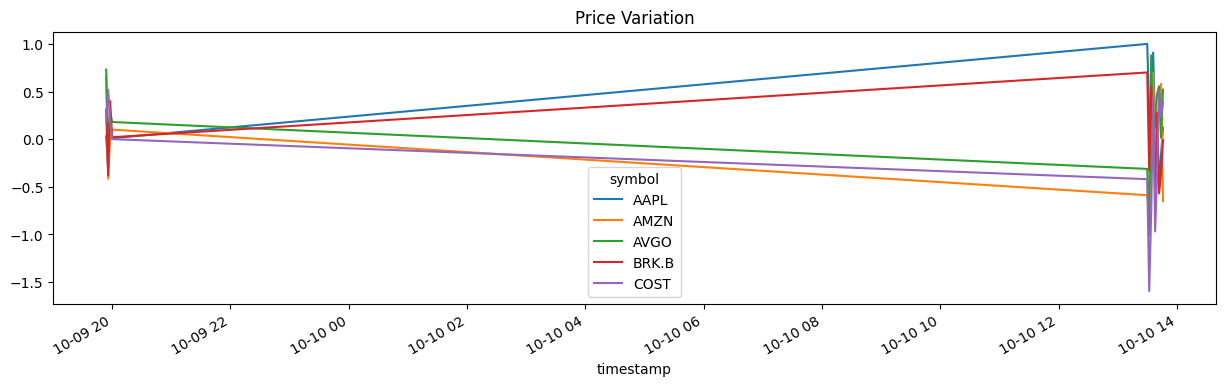

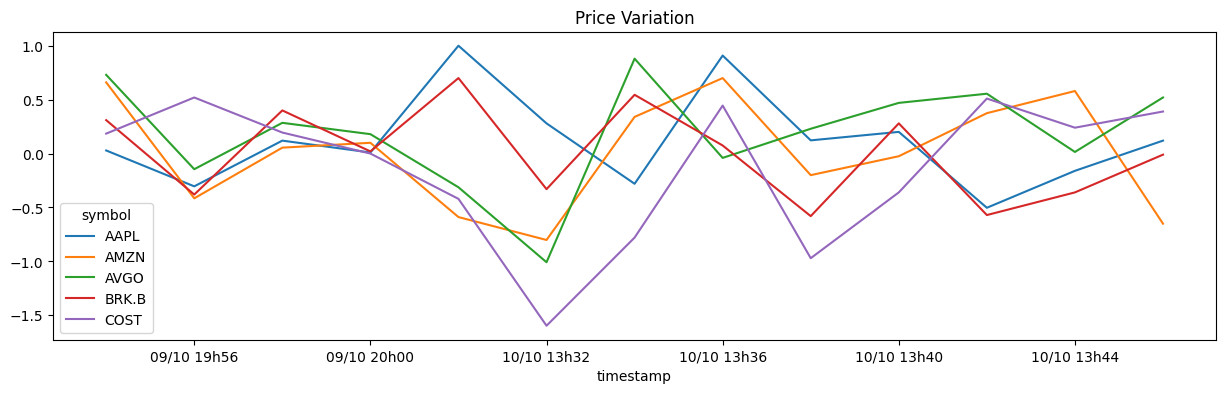

In [39]:
if unit_test_enabled :
    # Chart shows weekend's inactivity 
    plot_variation_prices( historical_data.iloc[ :, :5 ], nb_last_records=100, hide_closed_hours=False )  
    # Chart hides idle periods
    plot_variation_prices( historical_data.iloc[ :, :5 ], nb_last_records=100 )  

### Real-Time
Real-Time data

Goal : Get latest trading price for all tickers to complete the historical data

**Define function**

In [40]:
# Normal waiting time 
def normal_wait_until_next_run() :
    #log( 'started' )
    seconds_before_interval_ends = get_seconds_before_next_run()
    sleep( seconds_before_interval_ends )

def normal_wait_until( open_dt ) :
    #log( 'started' )
    nb_secs_before_open_dt  = ( open_dt - current_timestamp() ).seconds     
    nb_secs_before_open_str = str( timedelta( seconds=nb_secs_before_open_dt ) )
    log( f'Idle until {open_dt:%H:%M:%S} in {nb_secs_before_open_str} or {nb_secs_before_open_dt} sec.' )
    sleep( nb_secs_before_open_dt + 1 )
    
# Reduced waiting time for simulation
def simul_wait_until_next_run() :
    global clock_delay
    #log( 'started' )
    # Advance clock of N seconds
    delay_to_next_run =  get_seconds_before_next_run()
    # no offset for 0-delay before next run 
    if delay_to_next_run > 0 : clock_delay += delay_to_next_run - 1   
    
    #log( f'Time changed by {clock_delay} seconds' )
    # Call normal function 
    normal_wait_until_next_run()

def simul_wait_until( open_dt ) :
    global clock_delay
    #log( 'started' )
    # Advance clock of N seconds
    clock_delay = get_seconds_to_opening() - 1
    clock_delay_str = str( timedelta( seconds=clock_delay ) )
    log( f'Clock advanced by {clock_delay_str} or {clock_delay} seconds' )
    # Call normal function 
    normal_wait_until( open_dt )

# Choose function's definition
def get_prototypes( execution_mode ) :   # Choose normal or simulation functions
    if execution_mode == 'accelerated' : 
        return simul_wait_until, simul_wait_until_next_run, simul_get_ltps, simul_place_order
    else : 
        return normal_wait_until, normal_wait_until_next_run, normal_get_ltps, normal_place_order

In [41]:
def normal_get_ltps() : 
    # Wait for next interval
    #wait_until_next_run( INTERVAL, clock_delay )
    
    # Get next date index: remove fraction of seconds
    ltp_time = current_timestamp().replace( microsecond=0 )
    
    # Create request
    request_params = StockLatestTradeRequest( symbol_or_symbols=TICKERS )

    # Submit request
    trades = DATA_CLIENT.get_stock_latest_trade( request_params=request_params ) 

    # Convert dictionary of trades to Pandas
    dict_trades = [ dict( trade ) for trade in trades.values() ]
    df_trades = pd.DataFrame( dict_trades )
    df_trades[ 'timestamp' ] = ltp_time  # set unique index for all tickers
    df_ltps = df_trades.pivot( index='timestamp', columns='symbol', values='price' )
    #log( f'{ltps.iloc[0].values}' ) # print ltp values
    str_ltps = [ f'{i:#.1f}' for i in df_ltps.iloc[ 0 ][ :10 ] ]
    log( f'{' '.join( str_ltps )} ...' )

    return df_ltps

# Random variation of prices to simulate volatility
def simul_get_ltps() :     
    MAX_PCT_DELTA = 6    # max price variation
    df_ltps = normal_get_ltps()
    
    random_factor = 1 + random.randint( -MAX_PCT_DELTA, +MAX_PCT_DELTA ) / 100 
    df_ltps = df_ltps * random_factor
    
    str_ltps = [ f'{i:#.1f}' for i in df_ltps.iloc[ 0 ][ :10 ] ]
    log( f'{' '.join( str_ltps )} ... (random)' )

    return df_ltps
        
get_ltps = normal_get_ltps

In [42]:
def get_seconds_before_next_run() :
    current_time = current_timestamp()
    current_seconds = 60 * current_time.minute + current_time.second
    seconds_after_interval_started = current_seconds % INTERVAL 
    #log(f'{seconds_after_interval_started:#4d} seconds after current interval started')
    if seconds_after_interval_started > 0 :
        seconds_before_interval_ends = INTERVAL - seconds_after_interval_started        
    else : 
        seconds_before_interval_ends = 0
    #log( f'{seconds_before_interval_ends:#4d} seconds before next run' )
    return seconds_before_interval_ends 

**Check function**

In [43]:
if unit_test_enabled :
    ltps = simul_get_ltps()
    print(ltps)

22:13:28 normal_get_ltps():  258.4 218.0 340.4 491.6 944.7 252.5 251.7 192.9 294.1 812.6 ...
22:13:28  simul_get_ltps():  242.9 204.9 320.0 462.2 888.0 237.4 236.6 181.4 276.4 763.8 ... (random)
symbol                        AAPL      AMZN      AVGO    BRK.B      COST  \
timestamp                                                                   
2025-10-22 22:13:28+00:00  242.896  204.9012  320.0042  462.151  888.0086   

symbol                         GOOG     GOOGL      JNJ       JPM       LLY  \
timestamp                                                                    
2025-10-22 22:13:28+00:00  237.3594  236.5886  181.373  276.4446  763.8346   

symbol                     ...      META      MSFT       NFLX      NVDA  \
timestamp                  ...                                            
2025-10-22 22:13:28+00:00  ...  689.3302  489.2794  1049.6322  169.4632   

symbol                         ORCL      PLTR      TSLA         V       WMT  \
timestamp                        

### Generated
**Save Results**

Daily files with log messages, historical data & performance records

In [44]:
def save_results( daily_log, daily_history, daily_chrono, suffix='' ) :
    try : 
        # Daily historical data
        save_df_to_csv( f'hist{ suffix }_', daily_history, 'Historical Data' )
        # Chronometer records for performance measures
        chrono_results = get_chrono_results( daily_chrono )
        save_df_to_csv( f'chrono_ms{ suffix }_', chrono_results, 'Chronometer Records in ms' )
        # Daily updated orders
        daily_orders = get_daily_orders( current_timestamp().date() )
        save_df_to_csv( f'orders{ suffix }_', daily_orders, 'Orders Summary' )
    finally :
        # Log execution
        save_log( daily_log, suffix )    

## Orders
**Bracket Orders**

This type of order is a single order request that implies 3 : &nbsp; entry &nbsp; + &nbsp; target (profit-taking) &nbsp; + &nbsp; stop-loss (loss-limiting)

**Reference** : [Types](https://docs.alpaca.markets/docs/orders-at-alpaca#order-types) &emsp; [Lifecyle status & diagram](https://docs.alpaca.markets/docs/orders-at-alpaca#order-lifecycle) &emsp; [Fields of order object](https://docs.alpaca.markets/docs/brokerapi-trading#order-properties) &emsp; [Creation parameters](https://docs.alpaca.markets/reference/createorderforaccount) &emsp; [Validity - Time in force](https://docs.alpaca.markets/docs/orders-at-alpaca#time-in-force) &emsp; [Example](https://forum.alpaca.markets/t/bracket-order-code-example-with-alpaca-py-library/12110)

### Place
Place an order

**Define function**

In [45]:
def normal_place_order( current_price, ticker, quantity, signal ) :

    MIN_OFFSET = 0.015   # Minimum delta compared to base price ~= LTP 
    target   = round( ( 1 + signal * TARGET_PCT   / 100) * current_price, 2 )
    stoploss = round( ( 1 - signal * STOPLOSS_PCT / 100) * current_price - MIN_OFFSET, 2 ) 
    log( f'{ticker}: [target (take_profit.limit_price),  stoploss] = [{target}, {stoploss}]' )

    # Get position
    if signal == +1 :
        position = OrderSide.BUY  
    else : # Case signal == -1
        position = OrderSide.SELL
    
    # Set request parameters
    order_request = MarketOrderRequest(
        symbol        = ticker,
        qty           = quantity,
        side          = position,
        time_in_force = TimeInForce.GTC,  # Good unTil Cancelled != DAY that expires at close time
        order_class   = OrderClass.BRACKET,
        take_profit   = TakeProfitRequest( limit_price=target ),
        stop_loss     = StopLossRequest( stop_price=stoploss ),
    )    
    # Submit order request
    try : 
        submitted_order = TRADING_CLIENT.submit_order( order_data=order_request )
        log( f'{ticker}: submitted order \t ID = {submitted_order.id}' + 5*('=') )
        return submitted_order        
    except Exception as ex :
        log( f'{ticker}: ***** ERROR : Could not place order\n{eval( str( ex ) )}' )
        return None

wait_until, wait_until_next_run, get_ltps, place_order = get_prototypes( 'normal' )

In [46]:
# Random variation of prices to simulate volatility
def simul_place_order( curr_price, ticker, quantity, signal ) :

    MIN_OFFSET = 0.015   # Minimum delta compared to base price ~= LTP 
    target   = round( ( 1 + signal * TARGET_PCT   / 100) * curr_price, 2 )
    stoploss = round( ( 1 - signal * STOPLOSS_PCT / 100) * curr_price - MIN_OFFSET, 2 ) 
    log( f'{ticker}: [target (take_profit.limit_price),  stoploss] = [{target}, {stoploss}]' )

    # Get position
    if signal == +1 :
        position = OrderSide.BUY  
    else : # Case signal == -1
        position = OrderSide.SELL
    
    # Set request parameters
    order_request = MarketOrderRequest(
        symbol        = ticker,
        qty           = quantity,
        side          = position,
        time_in_force = TimeInForce.GTC,  # Good unTil Cancelled != DAY that expires at close time
        order_class   = OrderClass.BRACKET,
        take_profit   = TakeProfitRequest( limit_price=target ),
        stop_loss     = StopLossRequest( stop_price=stoploss ),
    )    
    # Submit order request
    try : 
        submitted_order = TRADING_CLIENT.submit_order( order_data=order_request )
        log( f'{ticker}: submitted order \t ID = {submitted_order.id}' + 5*('=') )
        return submitted_order        
    except Exception as ex :
        log( f'{ticker}: ***** ERROR : Could not place order' )
        # 2nd try to place order using base price
        dict_ex = eval( str( ex ) )
        log( f'{ticker}: {dict_ex}' )
        if ( 'base_price' in dict_ex.keys() ) :
            base_price = float( dict_ex[ 'base_price' ] )
            log( f'{ticker}: 2nd try to place order using base price' )
            random_factor = 1 - signal * random.randint( 2, 4 ) / 100 
            curr_price    = base_price * random_factor

            submitted_order = normal_place_order( curr_price, ticker, quantity, signal )
            return submitted_order        
        else :
            return None

**Check function**

In [47]:
if unit_test_enabled :
    ticker       = 'BRK.B' #'WOLF' # Wolfspeed Inc. LTP = $2.33 
    signal       = +1
    ticker_ltps  = get_ltps()[ ticker ].values[0]
    #submitted_order = place_order( ticker_ltps, ticker, QUANTITY, signal )

22:13:28 normal_get_ltps():  258.4 218.0 340.4 491.6 944.7 252.5 251.7 192.9 294.1 812.6 ...


### List
#### By status
List orders by status 

- status for executed orders : [ 'filled', 'canceled', 'rejected', 'expired' ]
- status for pending execution : [ 'accepted', 'new', 'pending new', 'held', 'partially filled' ]
- max list size is 500 (according to Alpaca's API)

**Define function**

In [48]:
def get_orders_by_status( status='all', verbose=True ) : # all pending canceled filled
    # Set target status
    if status == 'pending' : 
        order_statuses = [ 'accepted', 'new', 'held', 'partially filled' ]
    else : 
        order_statuses = [ status ]
    
    # Submit request to list all Ordersget_orders_by_status
    filter_all = GetOrdersRequest( status=QueryOrderStatus.ALL, limit=500 )
    all_orders_unformatted = TRADING_CLIENT.get_orders( filter=filter_all )

    try :
        # Convert Orders list to 1 Pandas
        all_orders = list_of_dicts_to_df( all_orders_unformatted ).set_index( 'id' )
        
        # Select Pandas' columns
        all_orders = all_orders[[ 'symbol', 'type', 'status', 'position_intent', 'limit_price', 'stop_price', 
                          'qty', 'created_at', 'updated_at', 'expires_at', 'canceled_at', 'time_in_force' ]]
        # Remove redundant key prefixes
        all_orders = remove_prefixes( all_orders)
    
        # Filter orders by status
        if status == 'all' :         
            # Count orders per status
            if verbose :
                orders_counts = all_orders[ 'status' ].value_counts()
                display( pd.DataFrame( orders_counts ) )
            return all_orders
        else :
            subset_orders = all_orders[ all_orders[ 'status' ].isin( order_statuses ) ]            
            subset_orders = remove_prefixes( subset_orders )
            return subset_orders
            
    except Exception as ex :
        print( f'***** ERROR : Could not get a list of orders as a Pandas' )
        log_exception( ex )
        return None    

In [49]:
def remove_prefixes( orders ) :
    orders.loc[ :, 'type' ]            = orders[ 'type' ]           .str.replace( 'OrderType', '' )
    orders.loc[ :, 'status' ]          = orders[ 'status' ]         .str.replace( 'OrderStatus', '' )
    orders.loc[ :, 'position_intent' ] = orders[ 'position_intent' ].str.replace( 'PositionIntent', '' )
    orders.loc[ :, 'time_in_force' ]   = orders[ 'time_in_force' ]  .str.replace( 'TimeInForce', '' )    
    return orders

**Check function**

In [50]:
if unit_test_enabled :
    all_orders = get_orders_by_status( 'all' ) # all pending canceled filled
    display( all_orders.head() )

,count
status,
canceled,341
filled,149
new,5
held,5


,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,updated_at,expires_at,canceled_at,time_in_force
id,,,,,,,,,,,,
c780dcd6-2341-4765-a33d-b71fc5535ec4,AMZN,stop,filled,sell_to_close,None,211.14,1,2025-10-10 16:40:06.157203+00:00,2025-10-17 15:25:27.213257+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
e0bd3ddf-7084-40d7-9c01-f52bce55a168,NFLX,stop,filled,sell_to_close,None,1184.75,1,2025-10-10 07:40:24.507869+00:00,2025-10-16 16:30:42.406744+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
695d2e07-b2cb-4b2f-ad65-08c4e72a1806,WMT,stop,filled,buy_to_close,None,104.52,1,2025-10-06 19:04:01.515040+00:00,2025-10-14 14:18:26.259026+00:00,2026-01-02 21:00:00+00:00,NaT,gtc
3f172612-d482-4fc9-910a-22f525be137e,MA,stop,filled,sell_to_close,None,553.8,1,2025-10-07 14:10:36.439263+00:00,2025-10-13 14:10:09.183373+00:00,2026-01-05 21:00:00+00:00,NaT,gtc
8c4dee9f-b6ba-4861-a8e2-556bb87df424,JPM,stop,filled,buy_to_close,None,309.37,1,2025-10-10 18:20:01.805977+00:00,2025-10-13 14:01:00.044089+00:00,2026-01-08 21:00:00+00:00,NaT,gtc


In [51]:
if unit_test_enabled :
    pending_orders = get_orders_by_status( 'pending', verbose=True ) # all pending canceled filled
    display( pending_orders.head() )

,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,updated_at,expires_at,canceled_at,time_in_force
id,,,,,,,,,,,,
e9910b53-857e-46ca-9fa9-25c83e4e4ea2,COST,limit,new,sell_to_close,967.05,None,1,2025-10-10 19:56:02.128534+00:00,2025-10-10 19:56:02.794993+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
34326528-7418-48d5-a946-efd6dd4524dc,COST,stop,held,sell_to_close,None,911.25,1,2025-10-10 19:56:02.128534+00:00,2025-10-10 19:56:02.133053+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
27cad777-4aad-4aed-8a85-22fd9ab2c202,BRK.B,limit,new,sell_to_close,501.72,None,1,2025-10-10 16:40:06.528755+00:00,2025-10-10 16:40:07.153040+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
bae8c3a7-46c3-41d2-93ea-7543d21caf03,BRK.B,stop,held,sell_to_close,None,472.76,1,2025-10-10 16:40:06.528755+00:00,2025-10-10 16:40:06.530953+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
26b132fe-5d96-49fd-a65f-d1bb6c81c871,MSFT,limit,new,sell_to_close,526.45,None,1,2025-10-09 21:29:20.157835+00:00,2025-10-10 13:30:44.782338+00:00,2026-01-08 21:00:00+00:00,NaT,gtc


#### Daily Orders

**Define function**

In [52]:
def get_daily_orders( date_in ) :
    all_orders   = get_orders_by_status( 'all', verbose=False )
    daily_mask   = ( all_orders[ 'created_at' ].apply( datetime.date ) == date_in )
    return all_orders [ daily_mask ]

**Check function**

Save to file

In [53]:
def save_df_to_csv( file_prefix, df_in, text_in='Pandas', timestamp=None ) :
    if len( df_in ) > 0 :
        if timestamp is None :
            timestamp = current_timestamp()            
        file_suffix = f'{timestamp:%Y%m%d}'
        file_path = CSV_DIR + file_prefix + file_suffix + '.csv'
        df_in.to_csv( file_path )
        log( f'{text_in} stored in : {file_path}' )
    else : 
        log( f'No file created for empty {text_in}' )

In [54]:
if unit_test_enabled : 
    date_to_check = datetime.today().date() - timedelta( days=1 )
    daily_orders = get_daily_orders( date_to_check )
    save_df_to_csv( 'orders_', daily_orders, 'Orders Summary', date_to_check )
    display( daily_orders.head() )    

22:13:29  save_df_to_csv():  No file created for empty Orders Summary


,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,updated_at,expires_at,canceled_at,time_in_force
id,,,,,,,,,,,,


Read from file

In [57]:
def read_df_from_csv( csv_path, index_column=None, timestamp_index=False ) :
    try :
        if index_column is None :
            df_out = pd.read_csv( csv_path )
        elif timestamp_index == False :
            #df_out = df_out.set_index( index_column )
            df_out = pd.read_csv( csv_path, index_col=index_column )
        else : 
            df_out = pd.read_csv( csv_path, index_col=index_column,  parse_dates=True )
        return df_out
    except Exception as ex :
        log( f'***** ERROR : Could not read Pandas from {csv_path}' )
        log_exception( ex )
        return pd.DataFrame()

In [58]:
if unit_test_enabled : 
    daily_orders_path = f'{CSV_DIR}orders_{date_to_check:%Y%m%d}.csv'
    daily_orders = read_df_from_csv( daily_orders_path, index_column='id' )
    display( daily_orders.head() )    

22:17:52 read_df_from_csv():  ***** ERROR : Could not read Pandas from ./data/alpaca/orders_20251022.csv
22:17:52 read_df_from_csv():  [Errno 2] No such file or directory: './data/alpaca/orders_20251022.csv'


""


Count daily orders' status by type and position intent

In [60]:
if unit_test_enabled : 
    try : 
        orders_count = daily_orders[[ 'position_intent', 'type', 'status' ]].value_counts()
        display( pd.DataFrame( orders_count ).sort_values( by=[ 'position_intent', 'type' ] ) )
    except : pass    

### Get info
#### By id
**Define function**

In [61]:
def check_bracket( order_id ) :
    order = TRADING_CLIENT.get_order_by_id( order_id )
    # convert to pandas
    selected_cols = [ 'symbol', 'type', 'status', 'position_intent', 'limit_price', 'stop_price', 
                          'qty', 'created_at', 'expires_at', 'time_in_force' ]
    o_dict = dict( order )
    if o_dict['legs'] is None :
        o_pandas = pd.DataFrame( o_dict, index=[ 'id' ] )
    else : 
        o_pandas = pd.DataFrame( o_dict ).set_index( 'id' )

    has_child_orders = ( o_pandas[ 'legs' ].iloc[0] != None )
    if has_child_orders :
        o_legs = o_pandas[ 'legs' ] 
        # print( 'This is a bracket order linked to 1 target order & 1 stoploss order' )
    o_pandas = o_pandas[ selected_cols ].drop_duplicates() 

    if has_child_orders :
        list_of_dicts = []
        for order in o_legs :
            order_dict = dict( order )
            list_of_dicts.append( order_dict )
        leg_pandas = pd.DataFrame( list_of_dicts ).set_index( 'id' )
        leg_pandas = leg_pandas[ selected_cols ] 
        
        o_pandas = pd.concat( [ o_pandas, leg_pandas ] )
        o_pandas = remove_prefixes( o_pandas )
        
    return o_pandas

**Check function**

In [62]:
if unit_test_enabled :
    display( check_bracket( 'cd6dcf94-b936-4577-befa-da305d9514e8' ) )

,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,expires_at,time_in_force
id,,,,,,,,,,
cd6dcf94-b936-4577-befa-da305d9514e8,WOLF,market,canceled,buy_to_open,None,None,1,2025-09-16 20:15:58.334501+00:00,2025-12-16 21:00:00+00:00,gtc
319492f1-6bee-4aa5-82af-f0c1b90e113d,WOLF,limit,canceled,sell_to_close,2.59,None,1,2025-09-16 20:15:58.334501+00:00,2025-12-16 21:00:00+00:00,gtc
fa850225-1872-4db2-830f-fe9ef1b82b57,WOLF,stop,canceled,sell_to_close,None,2.43,1,2025-09-16 20:15:58.334501+00:00,2025-12-16 21:00:00+00:00,gtc


#### Last bracket
**Define function**

In [63]:
def check_last_bracket() :
    all_orders = get_orders_by_status( 'all', verbose=False )
    bracket_orders = all_orders[ all_orders[ 'type' ]=='market' ]
    nb_bracket_orders = len( bracket_orders )
    if  nb_bracket_orders == 0 : 
        print( 'List of bracket orders is empty' )  
    else :
        last_bracket_order_id = bracket_orders.index[0]
        return check_bracket( last_bracket_order_id ) 

**Check function**

In [64]:
if unit_test_enabled :
    display( check_last_bracket() )

,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,expires_at,time_in_force
id,,,,,,,,,,
fe739f31-5f6f-4fff-b8e8-cc90c8452155,COST,market,filled,buy_to_open,None,None,1,2025-10-10 19:56:02.128534+00:00,2026-01-08 21:00:00+00:00,gtc
e9910b53-857e-46ca-9fa9-25c83e4e4ea2,COST,limit,new,sell_to_close,967.05,None,1,2025-10-10 19:56:02.128534+00:00,2026-01-08 21:00:00+00:00,gtc
34326528-7418-48d5-a946-efd6dd4524dc,COST,stop,held,sell_to_close,None,911.25,1,2025-10-10 19:56:02.128534+00:00,2026-01-08 21:00:00+00:00,gtc


### Cancel
#### By id
**Define function**

In [65]:
def cancel_order( order_id ) :
    # Check for bracket orders that may be canceled
        nb_pending_bracket_orders, _ = list_pending_bracket_orders()
        if nb_pending_bracket_orders > 0 :         
            try : 
                # Submit cancel request
                TRADING_CLIENT.cancel_order_by_id( order_id )
                # Get canceled order info
                order_info = TRADING_CLIENT.get_order_by_id( order_id )   
                sleep( 1 ) # wait until request is processed
                nb_pending_bracket_orders_after, _ = list_pending_bracket_orders()
                nb_canceled_orders = nb_pending_bracket_orders - nb_pending_bracket_orders_after
                if nb_canceled_orders == 1 :
                    print( f'order {order_id} was canceled' )
                else :
                    print( f'***** ERROR: order {order_id} could not be canceled' )
                    print( f'For more info run : check_bracket( "{order_id}" )' )
                return order_info
            except Exception as ex :
                log( f'***** ERROR : Could not cancel order {order_id}' )
                log_exception( ex )

In [66]:
def list_pending_bracket_orders( verbose=False ) :    
    pending_orders = get_orders_by_status( 'pending', verbose=False ) 
    nb_bracket_orders = len( pending_orders )
    if nb_bracket_orders == 0 : 
        if verbose : print( 'List of orders in pending state is empty' )   
        return nb_bracket_orders, None
    else :
        pending_bracket_orders = pending_orders[ pending_orders[ 'type' ]=='market' ]
        nb_pending_bracket_orders = len( pending_bracket_orders )
        if verbose : 
            if  nb_pending_bracket_orders == 0 :         
                #display( pending_orders )
                print( 'List of bracket orders in pending state is empty' )        
            else :
                print( 'Pending bracket orders' )
                selected_cols = [ 'symbol', 'type', 'status', 'position_intent',
                                  'limit_price', 'stop_price', 'qty', 'canceled_at' ]
                display( pending_bracket_orders[ selected_cols ] ) 
        return nb_pending_bracket_orders, pending_bracket_orders

**Check function**

In [68]:
if unit_test_enabled :
    canceled_order = cancel_order( '3913be09-d94c-4a76-a144-41135bd93927' )

#### Last pending order
**Define function**

In [69]:
def cancel_last_pending_order() :
    nb_orders, orders = list_pending_bracket_orders( verbose=True )
    if nb_orders > 0 :
        last_order_id = orders.index[0]
        cancel_order( last_order_id ) 

**Check function**

In [70]:
if unit_test_enabled :
    #cancel_last_pending_order()
    pass

#### All pending orders
**Define function**

In [71]:
def cancel_pending_brackets() :
    nb_orders, orders = list_pending_bracket_orders( verbose=True )
    while True : 
        if nb_orders == 0 :
            break
        last_order_id = orders.index[0]
        cancel_order( last_order_id ) 
        nb_orders, orders = list_pending_bracket_orders( verbose=False )

**Check function**

In [72]:
if unit_test_enabled :
    cancel_pending_brackets()
    pass

List of bracket orders in pending state is empty


### Order Book
In Alpaca Free Tier, 
- only last exchange's quote is available.
- an N-depth quote is available for **crypto-currencies** only

#### Last exchange's quote
**Define function**

In [73]:
def get_last_quote() :
    # Set request
    request_params = StockLatestQuoteRequest(
        symbol_or_symbols=TICKERS,
        feed=DataFeed.IEX # from the IEX feed
    )    
    try:
        # Submit request
        dict_of_quotes = DATA_CLIENT.get_stock_latest_quote(request_params)

        # Convert response to pandas
        dict_of_dicts = { key: dict(quote) for key, quote in dict_of_quotes.items() }
        df_out = pd.DataFrame.from_dict( dict_of_dicts, orient='index' )
        selected_cols = [ 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'timestamp' ]
        df_out = df_out[ selected_cols ].astype( { 'bid_size':int, 'ask_size':int } )
        df_out[ 'timestamp' ] = df_out[ 'timestamp' ] \
                                                .apply( lambda x: x.strftime( '%d/%m/%y-%Hh%Mm%Ss' ) )
        return df_out

    except Exception as ex :
        print( f'***** ERROR : Could not get last quote\n{ex}' )
        return None  

**Check function**

In [74]:
if unit_test_enabled :
    display( get_last_quote().head() )

,bid_price,bid_size,ask_price,ask_size,timestamp
COST,943.93,1,944.21,1,22/10/25-19h59m03s
V,345.29,1,360.01,1,22/10/25-19h59m49s
JNJ,181.40,1,202.23,1,22/10/25-20h00m00s
META,679.90,1,736.80,2,22/10/25-19h59m59s
NVDA,168.48,1,186.64,1,22/10/25-20h00m00s


#### 5-depth quote
- Get latest snapshot of order book
- Available only for Crypto-assets

**Define function**

In [75]:
def get_5_depth_quote() :
    depth = 5
    # Create request
    request_params = CryptoLatestOrderbookRequest( symbol_or_symbols=CRYPTO_TICKERS )
    try:
        # Submit request
        all_tickers_quotes = CRYPTO_DATA_CLIENT.get_crypto_latest_orderbook( request_params )    
        # Convert dictionary of quotes to pandas
        if len( all_tickers_quotes ) > 0 : 
            tickers_quotes = pd.DataFrame()
            for ticker in CRYPTO_TICKERS :
                # Convert dictionary of quotes to pandas
                one_ticker_dict = all_tickers_quotes[ ticker ]
                one_ticker_bids = pd.DataFrame( one_ticker_dict.model_dump()[ 'bids' ] )[ :depth ]
                one_ticker_asks = pd.DataFrame( one_ticker_dict.model_dump()[ 'asks' ] )[ :depth ]
                one_ticker_quotes = pd.concat( [ one_ticker_bids, one_ticker_asks ], axis=1 ) 
                new_headers = [ 'bid_price', 'bid_size', 'ask_price', 'ask_size' ]
                one_ticker_quotes.columns = new_headers
                one_ticker_quotes[ 'ticker' ] = ticker
                one_ticker_quotes = one_ticker_quotes[ [ 'ticker' ] + new_headers ]
                one_ticker_quotes[ 'timestamp' ] = one_ticker_dict.timestamp     
                # Concatenate ticker pandas 1 by 1
                tickers_quotes = pd.concat( [ tickers_quotes, one_ticker_quotes ], ignore_index=True )        
            return tickers_quotes    
    except Exception as ex :
        log( f'***** ERROR : Could not get 5-depth quote\n{ex}' )
        return None  

**Check function**

In [76]:
if unit_test_enabled :
    CRYPTO_TICKERS = [ 'BTC/USD', 'ETH/USD' ]
    CRYPTO_DATA_CLIENT = CryptoHistoricalDataClient()
    display( get_5_depth_quote() )

,ticker,bid_price,bid_size,ask_price,ask_size,timestamp
0,BTC/USD,107204.900,1.48235,107438.700,1.46864,2025-10-22 22:20:04.178128+00:00
1,BTC/USD,107185.600,2.94920,107476.273,2.92490,2025-10-22 22:20:04.178128+00:00
2,BTC/USD,107069.531,4.43194,107595.702,4.43770,2025-10-22 22:20:04.178128+00:00
3,BTC/USD,106880.300,5.88230,107798.600,5.88202,2025-10-22 22:20:04.178128+00:00
4,BTC/USD,106617.000,0.00354,108200.900,7.32080,2025-10-22 22:20:04.178128+00:00
5,ETH/USD,3749.930,22.96320,3755.670,23.00000,2025-10-22 22:19:33.400644+00:00
6,ETH/USD,3747.380,45.51900,3758.916,46.32580,2025-10-22 22:19:33.400644+00:00
7,ETH/USD,3743.470,69.12000,3761.300,68.42820,2025-10-22 22:19:33.400644+00:00
8,ETH/USD,3735.860,91.80100,3763.929,0.04000,2025-10-22 22:19:33.400644+00:00
9,ETH/USD,3721.900,114.30000,3769.571,91.68000,2025-10-22 22:19:33.400644+00:00


### Open Positions
#### List all

In [77]:
if unit_test_enabled :
    positions = TRADING_CLIENT.get_all_positions()
    display( list_of_dicts_to_df( positions ) )

,asset_id,symbol,exchange,asset_class,asset_marginable,avg_entry_price,qty,side,market_value,cost_basis,...,unrealized_plpc,unrealized_intraday_pl,unrealized_intraday_plpc,current_price,lastday_price,change_today,swap_rate,avg_entry_swap_rate,usd,qty_available
0,71bb19d0-6c5f-4881-9552-33224badd810,BRK.B,AssetExchange.NYSE,AssetClass.US_EQUITY,True,492.32,1,PositionSide.LONG,491.6996,492.32,...,-0.0012601559961001,0.4096,0.0008337234627206,491.6996,491.29,0.0008337234627206,None,None,None,0
1,1f888138-e413-4939-b16b-bdd08bb4debd,COST,AssetExchange.NASDAQ,AssetClass.US_EQUITY,True,930.69,1,PositionSide.LONG,946.42,930.69,...,0.0169014387175107,8.92,0.0095146666666667,946.42,937.5,0.0095146666666667,None,None,None,0
2,ef9adcc6-6bce-452b-af5f-4a87e7f19131,JNJ,AssetExchange.NYSE,AssetClass.US_EQUITY,True,185.68,-1,PositionSide.SHORT,-193.18,-185.68,...,-0.0403920723825937,-1.3,-0.0067750677506775,193.18,191.88,0.0067750677506775,None,None,None,0
3,b6d1aa75-5c9c-4353-a305-9e2caa1925ab,MSFT,AssetExchange.NASDAQ,AssetClass.US_EQUITY,True,521.45,1,PositionSide.LONG,521.43,521.45,...,-0.0000383545881676,3.77,0.0072827724761426,521.43,517.66,0.0072827724761426,None,None,None,0
4,092efc51-b66b-4355-8132-d9c3796b9a76,XOM,AssetExchange.NYSE,AssetClass.US_EQUITY,True,113.565,-1,PositionSide.SHORT,-115,-113.565,...,-0.0126359353674107,-2.29,-0.0203176293141691,115,112.71,0.0203176293141691,None,None,None,0


#### Liquidate
Close all open positions

**Define function**

In [78]:
def liquidate_all_open_positions() :
    positions = TRADING_CLIENT.get_all_positions()       # Get all open positions
    nb_positions = len( positions )
    print( f'{nb_positions} positions to liquidate' )
    if nb_positions > 0 :
        # Submit liquidation 
        responses = TRADING_CLIENT.close_all_positions(  # Close all open positions 
                        cancel_orders=True )             # Cancel all open orders first
        if len( responses ) > 0 :
            # Convert responses to Pandas with columns id & status
            list_tuples = [ [ resp.body.id, resp.status ] for resp in responses ]
            df_tuples = pd.DataFrame( list_tuples, columns=[ 'id', 'status'] ).set_index( 'id' )
            # Get Pandas with info of liquidated orders
            all_orders = get_orders_by_status( 'all', verbose=False ) 
            selected_orders = all_orders[ all_orders.index.isin( df_tuples.index ) ]
            # Concatenate columns of both Pandas 
            selected_orders = pd.concat( [ df_tuples, selected_orders ], axis=1 )
            display( selected_orders )    

**Check function**

In [79]:
if unit_test_enabled :
    #liquidate_all_open_positions()
    pass

# Main Process

## Pre-Process
**Define function**

In [80]:
def pre_process() :        
    CALENDAR = mcal.get_calendar( EXCHANGE )
    CLIENTS = [ get_data_client(), get_trading_client() ] # handle data & orders
    ORDER_PARAMS = { # required to place orders
        'QUANTITY'     : 1 ,
        'TARGET_PCT'   : 4 ,
        'STOPLOSS_PCT' : 2
    }    

    # Get strategy's parameters per ticker
    STRATEGY_PARAMS = get_strategy_params()
    # Display parameters
    print( 'Optimized parameters per ticker :')
    temporary_cols  = [ 'fast_window', 'long_entry', 'short_entry' ] 
    selected_cols   = [ 'ticker', 'slow_window' ] + temporary_cols
    display( STRATEGY_PARAMS[ selected_cols ].round( 1 ) )
    STRATEGY_PARAMS = STRATEGY_PARAMS.drop( columns=temporary_cols )
    
    # Set moving window size for all tickers
    MAX_SLOW_WINDOW_SIZE = round_up( STRATEGY_PARAMS[ 'slow_window' ].max() )
    WINDOW_SIZE = max( MAX_SLOW_WINDOW_SIZE, RSI_WINDOW_SIZE )    
    log( f'Max window size for all tickers : {WINDOW_SIZE}' )    
    STRATEGY_PARAMS = STRATEGY_PARAMS.drop( columns=[ 'slow_window' ] )

    # Get tickers list = intersection of 3 sets
    # 1. Set proposed by user in section "Variables"
    TICKERS_USER       = set( [ t.replace( '-', '.' ) for t in TICKERS_PROPOSED ] ) # Alpaca standard 
    # 2. Set issued from optimization process 
    TICKERS_OPTIMIZED  = set( list (STRATEGY_PARAMS[ 'ticker' ].values ) )
    # 3. Set of available tickers in exchange
    search_request = GetAssetsRequest( asset_class=AssetClass.US_EQUITY )
    assets_object  = TRADING_CLIENT.get_all_assets( search_request )
    assets_df      = pd.DataFrame( [ dict( asset ) for asset in assets_object ] )
    status_mask    = ( assets_df[ 'status' ] == AssetStatus.ACTIVE )
    TICKERS_AVAILABLE  = set( list( assets_df[ status_mask ][ 'symbol' ].values ) )
    # 4. List obtained 
    TICKERS            = list( TICKERS_USER & TICKERS_OPTIMIZED & TICKERS_AVAILABLE )    
    log( f'Selected tickers: {TICKERS}' )
    TICKERS_EXCLUDED   = list( ( TICKERS_USER | TICKERS_OPTIMIZED ) - TICKERS_AVAILABLE )
    log( f'Excluded tickers: {TICKERS_EXCLUDED}' )
    
    return TICKERS, CALENDAR, CLIENTS, STRATEGY_PARAMS, WINDOW_SIZE, ORDER_PARAMS

In [81]:
def get_strategy_params() :
    # Filter columns
    selected_cols = [ 'date', 'ticker', 'metric_type', 'slow_window', 'fast_window', 'long_entry', \
                      'short_entry', 'opt_params' ]
    parameters = pd.read_csv( STRATEGY_PARAMS_PATH, converters={ 'opt_params':eval } )[ selected_cols ]
    last_update = parameters[ 'date' ][ -1: ].values[ 0 ]
    #print( 'Last update on optimized parameters :', last_update )
    
    # Filter rows
    date_and_metric_masks = ( parameters[ 'date' ]==last_update ) & ( parameters[ 'metric_type' ]=='delta ratio' )
    parameters = parameters[ date_and_metric_masks ].drop( columns=[ 'date', 'metric_type' ] )
    parameters[ 'ticker' ] = parameters[ 'ticker' ].str.replace( '-', '.' ) # Adapt tickers to Alpaca standard 
    # Todo adapt code with index = ticker
    #parameters[ selected_cols ].set_index( 'ticker' )
    return parameters

get_strategy_params().round( 2 ).head(13)

,ticker,slow_window,fast_window,long_entry,short_entry,opt_params
1,NVDA,13.37,11.13,16.40,80.88,"[13.372498006484022, 11.128939847227866, 16.40..."
3,MSFT,63.26,46.15,18.90,80.72,"[63.260766785878744, 46.14893321613337, 18.898..."
5,AAPL,172.06,24.47,34.16,80.81,"[172.05918190706356, 24.465844448388214, 34.16..."
7,AMZN,155.87,39.64,23.70,84.16,"[155.87081274796498, 39.636409309935814, 23.70..."
9,GOOGL,192.11,28.67,33.11,86.21,"[192.11466885274334, 28.666670934851542, 33.10..."
11,GOOG,155.58,19.96,22.54,87.31,"[155.57676489542263, 19.95528532994963, 22.538..."
13,META,92.44,37.47,25.95,82.03,"[92.43789969742643, 37.47025461701195, 25.9526..."
15,AVGO,65.75,46.82,31.37,75.72,"[65.75287771709225, 46.81794587297561, 31.3650..."
17,TSLA,126.15,45.16,15.53,76.68,"[126.14590568181764, 45.1605948126045, 15.5317..."
19,BRK.B,118.74,13.84,20.60,78.40,"[118.738171946487, 13.838137304095927, 20.5966..."


## Daily Process
Calls run_daily_one_shot() & scan_trades()

In [82]:
def daily_process() :
    daily_history, daily_chrono = [], []  # chrono measures performance    
    current_time = current_timestamp()
    log( f'Today is {current_time.date():%a %d-%b}' )    
    
    try :
        if f_market_is_open_today() :  
            # Conditions on open times
            opening_time, closing_time = get_today_endpoints() # Replace by other existing f ?
            log( f' Today, market opens from {opening_time:%H:%M} to {closing_time:%H:%M} UTC' )
            market_opens_later    = ( current_time <= opening_time )        
            # Wait for opening time
            if market_opens_later : wait_until( opening_time )
            # Wait for next run
            elif f_market_is_still_open( closing_time ) : wait_until_next_run()
        
            # Run daily one-shot
            if f_market_is_still_open( closing_time ) : 
                daily_history = run_daily_one_shot( daily_history, closing_time )
            
            # Run job regularly before market closes        
            while f_market_is_still_open( closing_time ) :
                sleep( IDLE_TIME ) # avoids multiple runs during 1 second
                wait_until_next_run()        
                daily_history, daily_chrono = scan_trades( daily_history, daily_chrono )            
                #log( f'{daily_history[-1:].values}' )

    except Exception as ex :
        log( f'{ticker}: ***** ERROR : Daily process was interrupted' )
        log_exception( ex )        
        return daily_history, daily_chrono
    
    except KeyboardInterrupt: 
        log( 'Process interrupted by user.' ) 
        #log( f'{len(daily_history)} history records & {len(daily_chrono)} perf records')
        daily_process.interrupted = True
        return daily_history, daily_chrono
    
    log( 'Market is closed' )    
    return daily_history, daily_chrono

In [83]:
def get_chrono_results( chrono_list_of_records ) : # input in nano-s & output in mili-s
    chrono = pd.DataFrame( chrono_list_of_records, columns=CHRONO_COLS ).set_index( 'ticker' )
    chrono[ 'delta_signal' ]     = chrono[ 'signal_generated_time' ] - chrono[ 'ltp_received_time' ]
    chrono[ 'delta_signal_cpu' ] = chrono[ 'signal_generated_cpu' ]  - chrono[ 'ltp_received_cpu' ]
    chrono[ 'delta_order' ]      = chrono[ 'order_submitted_time' ]  - chrono[ 'ltp_received_time' ]
    chrono[ 'delta_order_cpu' ]  = chrono[ 'order_submitted_cpu' ]   - chrono[ 'ltp_received_cpu' ]
    chrono[ chrono.columns ] = ( chrono[ chrono.columns ] / 1e6 ).round( 1 ) 
    return chrono

In [84]:
if unit_test_enabled :
    daily_chrono = [ ['NVDA', *[57909497369, 1629441737304739], *[57957208836, 1629441816779205], *[ None, None ] ] ]
    display( get_chrono_results( daily_chrono ) )

,ltp_received_time,ltp_received_cpu,signal_generated_time,signal_generated_cpu,order_submitted_time,order_submitted_cpu,delta_signal,delta_signal_cpu,delta_order,delta_order_cpu
ticker,,,,,,,,,,
NVDA,57909.5,1.629442e+09,57957.2,1.629442e+09,NaN,NaN,47.7,79.5,NaN,NaN


## Daily One-Shot

In [85]:
def run_daily_one_shot( daily_history, closing_time ) :
    #log( 'One-shot st7f1c35e7-c173-40cc-b19d-ad54c0a9e523arted' )
    #chrono_start = [ process_time_ns(), perf_counter_ns() ] # Un-comment to measure performance 1/2
    ltps = complete_history( closing_time ) # Complete truncated historical LTPs due to Alpaca's feed delay
    daily_history = get_historical_data()

    # Concatenate both    
    daily_history = pd.concat( [ daily_history, ltps ] )

    # Display daily_history
    print( 'History sample (10 first tickers) :' )
    display( daily_history.iloc[ :, :10 ].round( 2 ) )
    
    # log( get_chrono( *chrono_start ) ) # Un-comment to measure performance 2/2
    #log( 'One-shot completed' )
    return daily_history

In [86]:
# Get last trading prices to complete truncated historical data due to Alpaca's feed delay 
def complete_history( closing_time ) :
    nb_truncated_records = round_up( HIST_MIN_DELAY / HIST_INTERVAL)
    log( f'Recovering {nb_truncated_records} records to complete historical data (15-minute gap)' )
    ltps = get_ltps()
    for i in range( nb_truncated_records - 1 ) :        
        sleep( 1 )
        if not f_market_is_still_open( closing_time ) : 
            next_opening, closing_time = get_next_sessions( CALENDAR, current_timestamp() ).iloc[ 0 ]
            wait_until( next_opening )
        wait_until_next_run()
        ltps = pd.concat( [ ltps, get_ltps() ] )

    # Get data info
    dates = ltps.index
    date_first, date_last = f'{dates.min():%B %d %Hh%M}', f'{dates.max():%B %d %Hh%M}'
    log( f'{len( ltps ):>4} additional  records from {date_first} to {date_last}' )   
        
    return ltps

# _ = complete_history()  # Un-comment to check function

## Scan Trades

For better performance :
- no custom function is called inside the for-loop of _scan_trades()_ -beside _log()_ & _chrono()_
- _generate_signals_c()_ is coded in C-language

In [87]:
def scan_trades( daily_history, daily_chrono ) :   
    # Update moving window on historical data
    daily_history = update_daily_history( daily_history )
    chrono_ltps_received = [ process_time_ns(), perf_counter_ns() ] # for performance
    moving_window = daily_history[ -WINDOW_SIZE: ]    
    # display( moving_window[ -10: ] ) # Un-comment to debug

    # Get tickers with neither open positions nor pending orders
    tickers_to_process = get_tickers_to_process()    
    # Scan tickers
    for ticker in tickers_to_process :
        try :
            # Get ticker's strategy parameters
            mask = ( STRATEGY_PARAMS[ 'ticker' ]==ticker )
            params_i = STRATEGY_PARAMS[ mask ][ 'opt_params' ].values[0]
            # Get ticker's moving window ('Close' column required to generate signal)
            slow_window_size = round_up( params_i[ 0 ] )
            window_size_i = max( RSI_WINDOW_SIZE, slow_window_size )  
            log( f'{ticker}: window size={window_size_i}' )                
            window_i = moving_window[[ ticker ]].rename( columns={ ticker:'Close' } )[ -window_size_i: ]
            # Choose signal generator's version : Python or C
            #window_i = generate_signal( window_i, RSI_WINDOW_SIZE, params_i, True, 'Close' )
            window_i = c_signal_gen.generate_signals_c( window_i, RSI_WINDOW_SIZE, params_i, True, 'Close' )
            chrono_signal_generated = [ process_time_ns(), perf_counter_ns() ] # performance
            # Get signal value
            last_record_i = window_i.iloc[ -1 ]
            signal_value = last_record_i[ 'Signal' ]
            if signal_value in [ -1, +1 ] :
                # Log signal record with indicators' values
                log_signal( last_record_i )
                # Place order
                current_price = last_record_i[ 'Close' ]
                new_order = place_order( current_price, ticker, QUANTITY, signal_value )
                chrono_order_submitted = [ process_time_ns(), perf_counter_ns() ] # performance
                if new_order is not None :
                    check_bracket( new_order.id )            
            else : 
                chrono_order_submitted  = [ None, None ] # performance
            # Log performance of blocks "generate signal", "place order" and both  
            daily_chrono.append( [ ticker, *chrono_ltps_received, *chrono_signal_generated, 
                                     *chrono_order_submitted ] )
        except Exception as ex :
            log( f'{ticker}: ***** ERROR : Could not process ticker' )
            log_exception( ex )            
            #print('scan_trades(): ', len(daily_history), len(daily_chrono))
            return daily_history, daily_chrono
        except KeyboardInterrupt: 
            scan_trades.interrupted = True
            log('Process interrupted by user')
            return daily_history, daily_chrono
            
    return daily_history, daily_chrono

Get tickers with open_positions & pending execution orders

In [88]:
def get_tickers_to_process() : 
    # ToDo : chrono delta ltp - signal - place order (return chrono start/go inside functions)
    
    # Get tickers_with open positions 
    open_positions = list_of_dicts_to_df( TRADING_CLIENT.get_all_positions() ) 
    tickers_open_positions = get_tickers_items( open_positions, 'open positions' )
    
    # Get tickers with pending target (limit) & stoploss orders
    pending_orders = get_orders_by_status( 'pending' )
    tickers_pending = []
    for type_i in [ 'market', 'limit', 'stop' ] :
        pending_orders_i = pending_orders[ pending_orders[ 'type' ]==type_i ]
        tickers_pending += get_tickers_items( pending_orders_i, f'pending {type_i} orders' )

    # Get tickers without open positions or pending orders
    tickers_to_skip = set( tickers_pending )
    tickers_to_process = list( set( TICKERS ) - tickers_to_skip )

    nb_tickers_to_process = len( tickers_to_process )
    log( f'{nb_tickers_to_process:>3} tickers to scan \n\t [{" ".join( tickers_to_process )}]' )
    return tickers_to_process

In [89]:
def get_tickers_items( items, text_in ) :
    nb_items = len( items.index )
    message  = f'{nb_items:>3} tickers with {text_in}'
    if nb_items > 0 :
        tickers_with_items = list( set( items[ 'symbol' ].values ) )
        tickers_with_items.sort()
        message += f'\n\t [{" ".join( tickers_with_items )}]'
    else :
        tickers_with_items = []
    log( message ) 

    return tickers_with_items

In [90]:
if unit_test_enabled :
    print( get_tickers_to_process() )

22:20:06 get_tickers_items():    5 tickers with open positions
	 [BRK.B COST JNJ MSFT XOM]
22:20:07 get_tickers_items():    0 tickers with pending market orders
22:20:07 get_tickers_items():    5 tickers with pending limit orders
	 [BRK.B COST JNJ MSFT XOM]
22:20:07 get_tickers_items():    5 tickers with pending stop orders
	 [BRK.B COST JNJ MSFT XOM]
22:20:07 get_tickers_to_process():   16 tickers to scan 
	 [JPM AVGO AMZN TSLA GOOGL NVDA GOOG AAPL META PLTR LLY NFLX ORCL V WMT MA]
['JPM', 'AVGO', 'AMZN', 'TSLA', 'GOOGL', 'NVDA', 'GOOG', 'AAPL', 'META', 'PLTR', 'LLY', 'NFLX', 'ORCL', 'V', 'WMT', 'MA']


In [91]:
def update_daily_history( daily_history ) :
    #chrono_start = [ process_time_ns(), perf_counter_ns() ]  # Un-comment to measure performance 1/2
    # Get last trading prices
    ltps = get_ltps()
    # Append to daily historical data
    daily_history = pd.concat( [ daily_history, ltps ] )
    #log( get_chrono( *chrono_start ) ) # Un-comment to measure performance 2/2
    return daily_history

In [92]:
def log_signal( signal_record ) :
    # Get string from Pandas row as field1=value1 field2=value2 ... 
    signal_results = [ f'{k}={int( v )}' if 'Signal' in k else f'{k}={v:.1f}' \
              for k, v in signal_record.to_dict().items() ]
    log( ' '.join( signal_results ) )

In [93]:
def f_market_is_open_today() :
    current_time = current_timestamp()
    period_time  = timedelta( days=7 ) # 1-week period
    schedule_window = CALENDAR.schedule( start_date = current_time - period_time, 
                                         end_date   = current_time )
    last_open_date  = schedule_window.index[ -1 ].date()    
    is_open_today   = ( last_open_date == current_time.date() )
    return is_open_today
    
def f_market_is_still_open( close_dt ) :
    curr_time = current_timestamp()    
    is_open_now = ( curr_time <= close_dt) 
    return is_open_now

**Check function**

Check _daily_process() = daily_one_shot()_ + _daily_process() execution_

In [94]:
if unit_test_enabled :
    clock_delay = get_seconds_to_dt( get_last_weekday( 'Thursday' ), [ 19, 24, 59 ] )
    wait_until, wait_until_next_run, get_ltps, place_order = get_prototypes( 'accelerated' )
    TICKERS, CALENDAR, CLIENTS, STRATEGY_PARAMS, WINDOW_SIZE, ORDER_PARAMS = pre_process()
    DATA_CLIENT, TRADING_CLIENT = CLIENTS
    QUANTITY, TARGET_PCT, STOPLOSS_PCT = ORDER_PARAMS.values()
    
    try :
        daily_history, daily_chrono = daily_process()
    except KeyboardInterrupt: 
        log('Process interrupted by user')
        
    clock_delay = 0

22:20:07 get_seconds_to_dt():  Target time "Thu 16-Oct 19:24:59" is 6 days, 2:55:08 or 528908 seconds behind
19:24:59 get_trading_client():  Account Status: AccountStatus.ACTIVE
19:24:59 get_trading_client():  Cash =  98,288.16$ Long Positions = 1,959.55$ Total =  99,939.53$ 
Optimized parameters per ticker :


,ticker,slow_window,fast_window,long_entry,short_entry
1,NVDA,13.4,11.1,16.4,80.9
3,MSFT,63.3,46.1,18.9,80.7
5,AAPL,172.1,24.5,34.2,80.8
7,AMZN,155.9,39.6,23.7,84.2
9,GOOGL,192.1,28.7,33.1,86.2
11,GOOG,155.6,20.0,22.5,87.3
13,META,92.4,37.5,26.0,82.0
15,AVGO,65.8,46.8,31.4,75.7
17,TSLA,126.1,45.2,15.5,76.7
19,BRK.B,118.7,13.8,20.6,78.4


19:24:59     pre_process():  Max window size for all tickers : 194
19:25:01     pre_process():  Selected tickers: ['PLTR', 'MA', 'AVGO', 'GOOGL', 'NVDA', 'XOM', 'ORCL', 'COST', 'V', 'LLY', 'TSLA', 'AAPL', 'NFLX', 'JPM', 'BRK.B', 'JNJ', 'AMZN', 'GOOG', 'META', 'MSFT', 'WMT']
19:25:01     pre_process():  Excluded tickers: []
19:25:01   daily_process():  Today is Thu 16-Oct
19:25:02   daily_process():   Today, market opens from 13:30 to 20:00 UTC
19:26:00 complete_history():  Recovering 8 records to complete historical data (15-minute gap)
19:26:00 normal_get_ltps():  258.4 218.0 340.4 491.6 944.7 252.5 251.7 192.9 294.1 812.6 ...
19:26:00  simul_get_ltps():  253.2 213.6 333.6 481.8 925.8 247.5 246.7 189.1 288.2 796.3 ... (random)
19:28:00 normal_get_ltps():  258.4 218.0 340.4 491.6 944.7 252.5 251.7 192.9 294.1 812.6 ...
19:28:00  simul_get_ltps():  271.3 228.9 357.5 516.2 991.9 265.1 264.3 202.6 308.8 853.2 ... (random)
19:30:00 normal_get_ltps():  258.4 218.0 340.4 491.6 944.7 252.5 25

symbol,AAPL,AMZN,AVGO,BRK.B,COST,GOOG,GOOGL,JNJ,JPM,LLY
timestamp,,,,,,,,,,
2025-10-15 19:30:00+00:00,249.89,215.33,352.82,494.53,954.26,251.17,250.50,191.50,306.61,828.60
2025-10-15 19:32:00+00:00,249.87,215.31,352.48,494.76,954.06,250.98,250.28,191.55,306.73,828.28
2025-10-15 19:34:00+00:00,249.58,215.05,351.50,494.61,953.78,250.76,250.09,191.54,306.69,827.50
2025-10-15 19:36:00+00:00,249.44,214.94,350.88,494.31,953.87,250.58,249.89,191.38,306.38,827.07
2025-10-15 19:38:00+00:00,249.26,214.84,350.86,494.14,953.44,250.49,249.82,191.39,306.48,826.76
...,...,...,...,...,...,...,...,...,...,...
2025-10-16 19:32:00+00:00,253.23,213.62,333.62,481.82,925.80,247.46,246.66,189.09,288.21,796.34
2025-10-16 19:34:00+00:00,242.90,204.90,320.00,462.15,888.01,237.36,236.59,181.37,276.44,763.83
2025-10-16 19:36:00+00:00,260.98,220.16,343.83,496.57,954.14,255.04,254.21,194.88,297.03,820.72


19:42:00 normal_get_ltps():  258.4 218.0 340.4 491.6 944.7 252.5 251.7 192.9 294.1 812.6 ...
19:42:00  simul_get_ltps():  248.1 209.3 326.8 472.0 906.9 242.4 241.6 185.2 282.3 780.1 ... (random)
19:42:00 get_tickers_items():    5 tickers with open positions
	 [BRK.B COST JNJ MSFT XOM]
19:42:01 get_tickers_items():    0 tickers with pending market orders
19:42:01 get_tickers_items():    5 tickers with pending limit orders
	 [BRK.B COST JNJ MSFT XOM]
19:42:01 get_tickers_items():    5 tickers with pending stop orders
	 [BRK.B COST JNJ MSFT XOM]
19:42:01 get_tickers_to_process():   16 tickers to scan 
	 [JPM AVGO AMZN TSLA GOOGL NVDA GOOG AAPL META PLTR LLY NFLX ORCL V WMT MA]
19:42:01     scan_trades():  JPM: window size=67
19:42:01     scan_trades():  AVGO: window size=66
19:42:01     scan_trades():  AMZN: window size=156
19:42:01     scan_trades():  TSLA: window size=127
19:42:01     scan_trades():  GOOGL: window size=193
19:42:01     scan_trades():  NVDA: window size=14
19:42:01     s

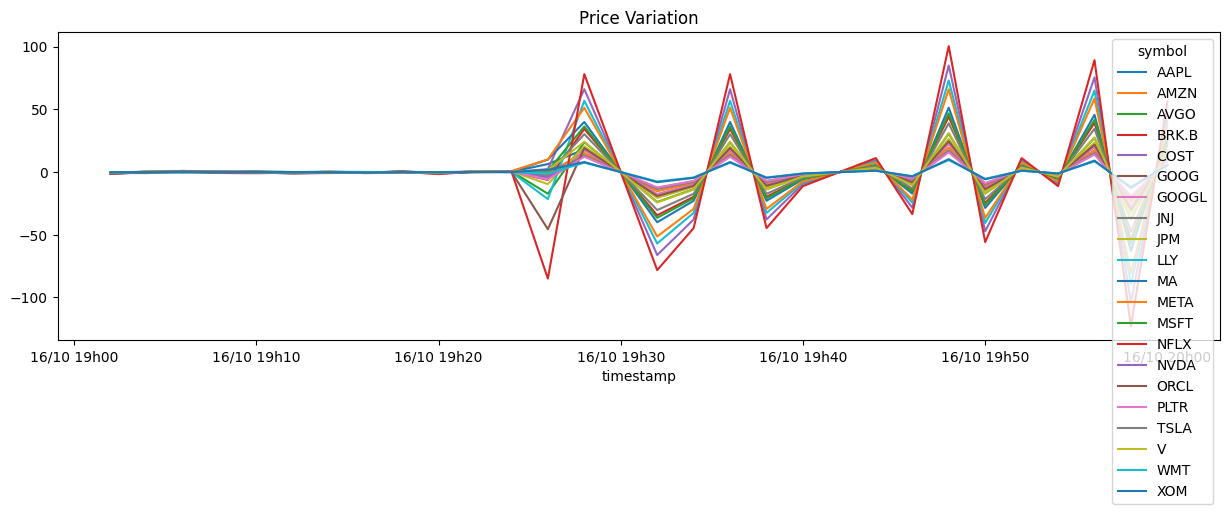

In [95]:
if unit_test_enabled and ( daily_history is not None ) : 
    #display( daily_history.T )
    plot_variation_prices( daily_history, nb_last_records=30 )

## Execution

### Normal execution 
**Normal** execution mode with actual time is set by default

In [96]:
execution_mode = 'normal'
clock_delay, file_suffix = 0 , ''

**Optional time simulation** 

For an execution with optional **simulated time**, select a weekday & a time-scenario for these simulated modes :
- **advanced** mode, launches on different dates (previous weekdays) & times
- **accelerated** mode, idem + reduces waiting time during the whole process

In [97]:
execution_mode = 'accelerated'  #  Uncomment & set: advanced or accelerated
time_scenario = 'PRE_CLOSE' 
weekday = 'Wednesday' # Monday Friday Saturday

TIME_SCENARII = {
    'CLOSED_AM' :   [ 8,  8,  8],  # Closed AM hours
    'PRE_OPEN' :    [10, 10, 10],  # Closed before opening
    'OPEN_MIDDAY' : [13, 29, 54],  # Open hours
    'PRE_CLOSE' :   [19, 44, 50]   # Open before closing
}
if execution_mode in [ 'advanced', 'accelerated' ] : 
    simulated_date = get_last_weekday( weekday ) 
    simulated_time = TIME_SCENARII[ time_scenario ] 
    clock_delay = get_seconds_to_dt( simulated_date, simulated_time )
    file_suffix = f'_{execution_mode}'

22:20:56 get_seconds_to_dt():  Target time "Wed 15-Oct 19:44:50" is 7 days, 2:36:06 or 614166 seconds behind


### Launch

In [ ]:
try :
    # Pre-process
    TICKERS, CALENDAR, CLIENTS, STRATEGY_PARAMS, WINDOW_SIZE, ORDER_PARAMS = pre_process()
    DATA_CLIENT, TRADING_CLIENT = CLIENTS
    QUANTITY, TARGET_PCT, STOPLOSS_PCT = ORDER_PARAMS.values()
    daily_log, daily_history, daily_chrono = '', [], []
    wait_until, wait_until_next_run, get_ltps, place_order = get_prototypes( execution_mode )
    daily_process.interrupted, scan_trades.interrupted = False, False # Function's attributes
    
    while True :    # Repeat everyday
        
        # Daily process
        daily_history, daily_chrono = daily_process()
        if daily_process.interrupted or scan_trades.interrupted : 
            raise KeyboardInterrupt
            
        # Log results
        save_results( daily_log, daily_history, daily_chrono, file_suffix )
        daily_log, daily_history, daily_chrono = '', [], []
        
        # Wait for next opening day
        idle_time = get_seconds_to_opening() - 2*60*60 # time to 2 hours before market opens
        if execution_mode == 'accelerated' : 
            clock_delay = idle_time # advance clock by idle time
        else : 
            sleep( idle_time )      # do nothing during idle time
        
except SystemExit :
    log('Program terminated due to critical error')
    save_results( daily_log, daily_history, daily_chrono, file_suffix )
except KeyboardInterrupt: 
    log('Process interrupted by user')
    save_results( daily_log, daily_history, daily_chrono, file_suffix )

20:02:48 get_trading_client():  Account Status: AccountStatus.ACTIVE
20:02:48 get_trading_client():  Cash =  98,288.16$ Long Positions = 1,959.61$ Total =  99,939.59$ 
Optimized parameters per ticker :


,ticker,slow_window,fast_window,long_entry,short_entry
1,NVDA,13.4,11.1,16.4,80.9
3,MSFT,63.3,46.1,18.9,80.7
5,AAPL,172.1,24.5,34.2,80.8
7,AMZN,155.9,39.6,23.7,84.2
9,GOOGL,192.1,28.7,33.1,86.2
11,GOOG,155.6,20.0,22.5,87.3
13,META,92.4,37.5,26.0,82.0
15,AVGO,65.8,46.8,31.4,75.7
17,TSLA,126.1,45.2,15.5,76.7
19,BRK.B,118.7,13.8,20.6,78.4


20:02:48     pre_process():  Max window size for all tickers : 194
20:02:51     pre_process():  Selected tickers: ['PLTR', 'MA', 'AVGO', 'GOOGL', 'NVDA', 'XOM', 'ORCL', 'COST', 'V', 'LLY', 'TSLA', 'AAPL', 'NFLX', 'JPM', 'BRK.B', 'JNJ', 'AMZN', 'GOOG', 'META', 'MSFT', 'WMT']
20:02:51     pre_process():  Excluded tickers: []
20:02:51   daily_process():  Today is Wed 15-Oct
20:02:51   daily_process():   Today, market opens from 13:30 to 20:00 UTC
20:02:51   daily_process():  Market is closed
20:02:51  save_df_to_csv():  No file created for empty Historical Data
20:02:51  save_df_to_csv():  No file created for empty Chronometer Records in ms
20:02:51  save_df_to_csv():  No file created for empty Orders Summary
20:02:51        save_log():  Log messages stored in : ./log/alpaca/api_orders_accelerated_20251015.log
20:02:52 get_seconds_to_opening():  Market opens in a future day
20:02:52 get_seconds_to_dt():  Target time "Thu 16-Oct 13:30:00" is 6 days, 8:54:07 or 550447 seconds behind
11:30:0

### Check Results

Set date to check 'YYYYMMDD'

In [ ]:
exec_date = '20251010'

Log File

In [ ]:
! grep "submitted" ./log/alpaca/api_orders_{ exec_date }.log | cut -d":" -f 4 | sort | tr "\n" " "

  AVGO   COST   GOOGL   JPM 

In [ ]:
! grep "ERROR" ./log/alpaca/api_orders_{ exec_date }.log | cut -d":" -f 4  | sort | uniq -c #tr "\n" " "

Historical Data

In [ ]:
daily_history_path = f'./data/alpaca/hist_{ exec_date }.csv'
daily_history = read_df_from_csv( daily_history_path, index_column='timestamp', timestamp_index=True )
print( daily_history.info( verbose=False ) )
daily_history.round( 1 ).head( 1 )

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 282 entries, 2025-10-09 17:10:00+00:00 to 2025-10-10 20:00:00+00:00
Columns: 21 entries, AAPL to XOM
dtypes: float64(21)
memory usage: 48.5 KB
None


,AAPL,AMZN,AVGO,BRK.B,COST,GOOG,GOOGL,JNJ,JPM,LLY,...,META,MSFT,NFLX,NVDA,ORCL,PLTR,TSLA,V,WMT,XOM
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-10-09 17:10:00+00:00,253.6,223.8,342.7,495.7,941.6,241.7,241.0,191.3,304.6,851.8,...,726.7,518.9,1236.2,192.9,298.0,181.9,430.3,347.8,101.2,113.5


Orders Summary

In [ ]:
daily_orders_path = f'./data/alpaca/orders_{ exec_date }.csv'
daily_orders = read_df_from_csv( daily_orders_path, index_column='id' )
print( daily_orders[[ 'type', 'status' ]].groupby(by=[ 'type' ]).value_counts() )
daily_orders.head( 1 )

type    status  
limit   new         8
        filled      1
market  filled      9
stop    held        8
        canceled    1
Name: count, dtype: int64


,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,updated_at,expires_at,canceled_at,time_in_force
id,,,,,,,,,,,,
e9910b53-857e-46ca-9fa9-25c83e4e4ea2,COST,limit,new,sell_to_close,967.05,NaN,1,2025-10-10 19:56:02.128534+00:00,2025-10-10 19:56:02.794993+00:00,2026-01-08 21:00:00+00:00,NaN,gtc


Performance

In [ ]:
chrono_path = f'./data/alpaca/chrono_ms_{ exec_date }.csv'
chrono = read_df_from_csv( chrono_path, index_column='ticker' )                           
chrono = chrono[[ 'delta_signal', 'delta_order', 'delta_signal_cpu', 'delta_order_cpu' ]] 
signal_with_order = ~( chrono[ 'delta_order' ].isna() )
print( 'Stats & sample of signals followed by 1 order' )
display( chrono[ signal_with_order ].describe().loc[[ 'min', 'mean', 'max' ]].round( 1 ) )
display( chrono[ signal_with_order ].head(1) )
print( 'Stats & sample of signals followed by NO order' )
display( chrono[ ~signal_with_order ].describe().loc[[ 'min', 'mean', 'max' ]].round( 1 ) )
display( chrono[ ~signal_with_order ].head(1) ) 

Stats & sample of signals followed by 1 order


,delta_signal,delta_order,delta_signal_cpu,delta_order_cpu
min,112.9,116.1,696.9,818.4
mean,120.2,123.0,785.1,906.5
max,139.9,142.5,984.2,1112.5


,delta_signal,delta_order,delta_signal_cpu,delta_order_cpu
ticker,,,,
AVGO,113.4,116.4,728.8,845.0


Stats & sample of signals followed by NO order


,delta_signal,delta_order,delta_signal_cpu,delta_order_cpu
min,108.7,NaN,677.1,NaN
mean,116.4,NaN,740.9,NaN
max,162.8,NaN,1433.8,NaN


,delta_signal,delta_order,delta_signal_cpu,delta_order_cpu
ticker,,,,
AVGO,112.8,NaN,686.8,NaN


**End Process**

In [ ]:
assert False, 'Everything OK: End of process'  # prevents the execution of following cells

# Annex
## Monitor orders

This table shows the impact of cancellations during the lifecycle of a Bracket Order (Market and Leg orders)

|Author|Action|Object|Market|Stop-Loss|Target|Cancellable*|
|--|--|--|--|--|--|--|
|Trader|submits|Bracket|new|-|-|Bracket|
|Broker|holds|legs|-|held|new|Bracket|
|Broker|validates|market|pending new|-|-|Bracket|
|Exchange|accepts|market|accepted|-|-|Bracket|
|Exchange|fills|market|filled**|-|-|Legs|
|Exchange|accepts|legs|-|accepted|accepted|Legs|
|Trader|liquidates|open position|new (opposite open position)|canceled*|canceled*|-|
|Exchange|fills|1 leg|closed position|filled / auto-canceled|auto-canceled / filled|-|

- \* : Trader may cancel an order to end its process
- NB : _partially filled_ status is not covered by this table

In [ ]:
#_, _, _, TRADING_CLIENT, _, _, _ = pre_process() 

In [ ]:
! grep -H "submitted" ./log/alpaca/api_orders_202510*.log

./log/alpaca/api_orders_20251010.log:18:04:02 normal_place_order():  AVGO: submitted order 	 ID = 457eac5e-f439-4ed9-850e-29a6eb87d87e=====
./log/alpaca/api_orders_20251010.log:18:20:01 normal_place_order():  JPM: submitted order 	 ID = 97c12c11-04c0-4850-b4cb-5a6edacb281e=====
./log/alpaca/api_orders_20251010.log:19:56:01 normal_place_order():  GOOGL: submitted order 	 ID = 70f5eba1-d7b3-416e-992d-99113bf21e1b=====
./log/alpaca/api_orders_20251010.log:19:56:02 normal_place_order():  COST: submitted order 	 ID = fe739f31-5f6f-4fff-b8e8-cc90c8452155=====


### Check pending Market orders

In [ ]:
nb_pending_bracket_orders, pending_bracket_orders =  list_pending_bracket_orders()
print( f'{nb_pending_bracket_orders} pending_bracket_orders' )
display( pending_bracket_orders )

0 pending_bracket_orders


,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,updated_at,expires_at,canceled_at,time_in_force
id,,,,,,,,,,,,


### Cancel single Bracket

In [ ]:
_ = cancel_order( '34909003-18fd-42e6-b493-b51ed0782e20' )

### Cancel Brackets

In [ ]:
#cancel_pending_brackets()

### Check all pending orders

In [ ]:
pending_orders = get_orders_by_status( 'pending' )
print( f'{len( pending_orders )} pending_orders' )
print( pending_orders[[ 'type', 'status' ]].groupby(by=[ 'type' ]).value_counts() ) 
pending_orders

36 pending_orders
type   status
limit  new       18
stop   held      18
Name: count, dtype: int64


,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,updated_at,expires_at,canceled_at,time_in_force
id,,,,,,,,,,,,
e9910b53-857e-46ca-9fa9-25c83e4e4ea2,COST,limit,new,sell_to_close,967.05,None,1,2025-10-10 19:56:02.128534+00:00,2025-10-10 19:56:02.794993+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
9731a2db-dfc4-4887-90a5-0f77a87a23dd,GOOGL,limit,new,sell_to_close,245.65,None,1,2025-10-10 19:56:01.868160+00:00,2025-10-10 19:56:02.274764+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
34326528-7418-48d5-a946-efd6dd4524dc,COST,stop,held,sell_to_close,None,911.25,1,2025-10-10 19:56:02.128534+00:00,2025-10-10 19:56:02.133053+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
ea8a6ee4-092d-4f4c-88d5-d907b9fac51f,GOOGL,stop,held,sell_to_close,None,231.46,1,2025-10-10 19:56:01.868160+00:00,2025-10-10 19:56:01.869888+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
41295982-2bf2-42a1-b5b4-56d8eaac686e,JPM,limit,new,buy_to_close,291.18,None,1,2025-10-10 18:20:01.805977+00:00,2025-10-10 18:20:01.956584+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
8c4dee9f-b6ba-4861-a8e2-556bb87df424,JPM,stop,held,buy_to_close,None,309.37,1,2025-10-10 18:20:01.805977+00:00,2025-10-10 18:20:01.808055+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
b74ae202-9766-4b95-b6fd-d081a69a58e4,AVGO,limit,new,sell_to_close,342.47,None,1,2025-10-10 18:04:02.286875+00:00,2025-10-10 18:04:02.922904+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
736edac9-aea4-4f4a-bf7a-9c5225087325,AVGO,stop,held,sell_to_close,None,322.7,1,2025-10-10 18:04:02.286875+00:00,2025-10-10 18:04:02.288662+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
27cad777-4aad-4aed-8a85-22fd9ab2c202,BRK.B,limit,new,sell_to_close,501.72,None,1,2025-10-10 16:40:06.528755+00:00,2025-10-10 16:40:07.153040+00:00,2026-01-08 21:00:00+00:00,NaT,gtc


### Custom search

Get Pandas with all orders

In [ ]:
all_orders = get_orders_by_status( 'all' )
all_orders.head( 1 )

,count
status,
canceled,328
filled,136
new,18
held,18


,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,updated_at,expires_at,canceled_at,time_in_force
id,,,,,,,,,,,,
e9910b53-857e-46ca-9fa9-25c83e4e4ea2,COST,limit,new,sell_to_close,967.05,None,1,2025-10-10 19:56:02.128534+00:00,2025-10-10 19:56:02.794993+00:00,2026-01-08 21:00:00+00:00,NaT,gtc


Select a ticker

In [ ]:
orders_1_ticker = all_orders[ all_orders [ 'symbol' ] == 'GOOG' ]  # Search by ticker
orders_1_ticker.head(1)

,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,updated_at,expires_at,canceled_at,time_in_force
id,,,,,,,,,,,,
d64b6533-b408-4d36-ae0c-fd20d81ff440,GOOG,limit,new,sell_to_close,246.75,None,1,2025-10-09 21:30:23.024708+00:00,2025-10-10 13:30:38.643431+00:00,2026-01-08 21:00:00+00:00,NaT,gtc


Get counts

In [ ]:
orders_1_ticker[[ 'type', 'position_intent', 'status' ]].groupby(by=[ 'type', 'position_intent' ]).value_counts() 

type    position_intent  status  
limit   buy_to_close     canceled    1
                         filled      1
        sell_to_close    canceled    3
                         new         1
market  buy_to_open      canceled    2
                         filled      2
        sell_to_close    canceled    3
                         filled      1
        sell_to_open     canceled    1
                         filled      1
stop    buy_to_close     canceled    2
        sell_to_close    canceled    3
                         held        1
Name: count, dtype: int64

Get Bracket count by date

In [ ]:
ost = os[ os[ 'type' ]=='market' ]
ost[ 'created_at' ].apply( datetime.date ).value_counts().sort_index( ascending=False )

created_at
2025-10-09    2
2025-10-07    2
2025-10-06    4
2025-10-05    1
2025-10-03    1
Name: count, dtype: int64

### Check daily orders

In [ ]:
get_daily_orders( date( 2025, 10, 10 ) )
#get_daily_orders( current_timestamp().date() )

,symbol,type,status,position_intent,limit_price,stop_price,qty,created_at,updated_at,expires_at,canceled_at,time_in_force
id,,,,,,,,,,,,
e9910b53-857e-46ca-9fa9-25c83e4e4ea2,COST,limit,new,sell_to_close,967.05,None,1,2025-10-10 19:56:02.128534+00:00,2025-10-10 19:56:02.794993+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
9731a2db-dfc4-4887-90a5-0f77a87a23dd,GOOGL,limit,new,sell_to_close,245.65,None,1,2025-10-10 19:56:01.868160+00:00,2025-10-10 19:56:02.274764+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
fe739f31-5f6f-4fff-b8e8-cc90c8452155,COST,market,filled,buy_to_open,None,None,1,2025-10-10 19:56:02.128534+00:00,2025-10-10 19:56:02.782594+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
34326528-7418-48d5-a946-efd6dd4524dc,COST,stop,held,sell_to_close,None,911.25,1,2025-10-10 19:56:02.128534+00:00,2025-10-10 19:56:02.133053+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
70f5eba1-d7b3-416e-992d-99113bf21e1b,GOOGL,market,filled,buy_to_open,None,None,1,2025-10-10 19:56:01.868160+00:00,2025-10-10 19:56:02.259622+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
ea8a6ee4-092d-4f4c-88d5-d907b9fac51f,GOOGL,stop,held,sell_to_close,None,231.46,1,2025-10-10 19:56:01.868160+00:00,2025-10-10 19:56:01.869888+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
41295982-2bf2-42a1-b5b4-56d8eaac686e,JPM,limit,new,buy_to_close,291.18,None,1,2025-10-10 18:20:01.805977+00:00,2025-10-10 18:20:01.956584+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
97c12c11-04c0-4850-b4cb-5a6edacb281e,JPM,market,filled,sell_to_open,None,None,1,2025-10-10 18:20:01.805977+00:00,2025-10-10 18:20:01.947600+00:00,2026-01-08 21:00:00+00:00,NaT,gtc
8c4dee9f-b6ba-4861-a8e2-556bb87df424,JPM,stop,held,buy_to_close,None,309.37,1,2025-10-10 18:20:01.805977+00:00,2025-10-10 18:20:01.808055+00:00,2026-01-08 21:00:00+00:00,NaT,gtc


## Monitor Positions
The position of an account only changes when a trade is filled 
- Open = you hold shares or are short
- Closed = you hold no shares

### Check Open Positions

In [ ]:
positions = TRADING_CLIENT.get_all_positions()
nb_positions = len( positions )
if nb_positions > 0 :
    open_pos = list_of_dicts_to_df( positions ) \
        [[ 'symbol', 'side', 'market_value', 'qty_available', 'unrealized_plpc']]
    print( f'{nb_positions} open positions' )
    display( open_pos )

18 open positions


,symbol,side,market_value,qty_available,unrealized_plpc
0,AAPL,PositionSide.LONG,244.5,0,-0.0400471142520612
1,AMZN,PositionSide.LONG,214.75,0,-0.0231532023289665
2,AVGO,PositionSide.LONG,323.5,0,-0.0186561504626119
3,BRK.B,PositionSide.LONG,485.8,0,-0.0132434189145271
4,COST,PositionSide.LONG,922.21,0,-0.0089091886082751
5,GOOG,PositionSide.LONG,235.5,0,-0.0274623167458187
6,GOOGL,PositionSide.LONG,235.1,0,-0.0046149286591304
7,JNJ,PositionSide.SHORT,-190.58,0,-0.0263894872899612
8,JPM,PositionSide.SHORT,-299,0,0.014502307185234
9,LLY,PositionSide.LONG,827,0,-0.0232668005196646


### Compare Prices

Compare prices in open positions vs. pending orders.

**_qty_available_** = nb of owned stocks - nb reserved in open positions
- prevents from creating an order with "insufficient qty available for order".
    - 0 : no new order is required to close the position
    - positive/negative : a new sell/buy order would be required

In [ ]:
def compare_prices() :
    # Get prices from limit & stop orders per ticker
    pending_orders = get_orders_by_status( 'pending' )
    pending_limit_orders = pending_orders[ pending_orders[ 'type' ]== 'limit' ].set_index( 'symbol' ) \
                                                        [[ 'position_intent', 'limit_price', 'qty' ]]
    pending_stop_orders  = pending_orders[ pending_orders[ 'type' ]== 'stop'  ].set_index( 'symbol' ) \
                                                        [[ 'position_intent', 'stop_price', 'qty' ]]
    pending_orders_prices = pd.merge( pending_limit_orders, pending_stop_orders, how='outer', 
                                                        on=[ 'symbol','position_intent','qty' ] )
    # Get market prices from open positions per ticker
    positions = TRADING_CLIENT.get_all_positions()
    open_positions = list_of_dicts_to_df( positions ).set_index( 'symbol' ) \
                                                        [[ 'side', 'market_value', 'qty_available' ]]
    # Join pandas
    position_vs_order_prices = pd.merge( open_positions, pending_orders_prices, how='outer', on=[ 'symbol' ] ) \
                [[ 'side', 'position_intent', 'limit_price', 'market_value', 'stop_price', 'qty', 'qty_available' ]]
    position_vs_order_prices = position_vs_order_prices. \
        astype( { 'limit_price':float, 'market_value':float, 'stop_price':float } ). \
        sort_values( by='side' )
    return round( position_vs_order_prices, 1 )

compare_prices()

,side,position_intent,limit_price,market_value,stop_price,qty,qty_available
symbol,,,,,,,
AAPL,PositionSide.LONG,sell_to_close,258.9,244.6,244.0,1,0
AMZN,PositionSide.LONG,sell_to_close,224.1,215.0,211.1,1,0
AVGO,PositionSide.LONG,sell_to_close,342.5,324.0,322.7,1,0
BRK.B,PositionSide.LONG,sell_to_close,501.7,485.8,472.8,1,0
COST,PositionSide.LONG,sell_to_close,967.0,922.2,911.2,1,0
GOOG,PositionSide.LONG,sell_to_close,246.8,236.1,232.5,1,0
GOOGL,PositionSide.LONG,sell_to_close,245.6,235.4,231.5,1,0
LLY,PositionSide.LONG,sell_to_close,879.9,827.0,829.1,1,0
MA,PositionSide.LONG,sell_to_close,587.7,555.5,553.8,1,0


### Liquidate Positions
A position is opened when the market order of a bracket is filled
- if an exit leg is then canceled, the other leg is automatically canceled 
- the position remains open and you should close it manually or liquidate it
    - during closed hours, orders are queued for execution at the next trading session
    - between 4am & 8pm, limit orders (TIF=day & extended_hours=True) may be executed

In [ ]:
#liquidate_all_open_positions()

## Plot variation prices

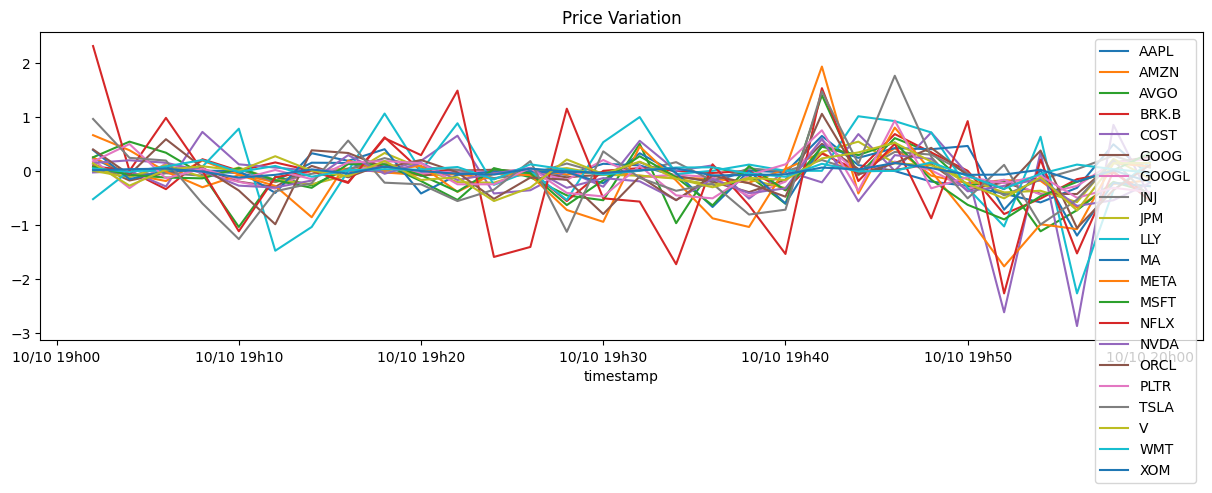

In [ ]:
plot_variation_prices( daily_history, nb_last_records=30 )

**Theory**
- Derivative contracts
    - **Future** : both, buyer and seller, are compelled to trade at strike price on expiration date
    - **Option** : its writer is compelled to trade while its holder has 2 options, trade or lose the premium.
- **Futures Market** : has 2 advantages over Live Market
    - it's open 24/5
    - it requires no minimum account balance 